In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from cleaning_data import clean
from get_macrodata import monthly_data
import sys
from scipy.optimize import minimize

Текущая рабочая директория: c:\Users\vasil\YandexDisk\project\LK_and_commets 
Оттуда буду брать данные, там должна быть папка data, а в ней данные по годам


c:\Users\vasil\AppData\Local\Programs\Python\Python313\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\vasil\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [2]:
monthly_data['spread'] =  monthly_data.loc[:, 'ruonia'] - monthly_data.loc[:, 'rate_1']
monthly_data['spread_3m'] =  monthly_data.loc[:, 'ruonia'] - monthly_data.loc[:, 'ruonia_3m']
monthly_data['spread_1m'] =  monthly_data.loc[:, 'ruonia'] - monthly_data.loc[:, 'ruonia_1m']

var_spec = clean(monthly_data.loc[monthly_data.index > dt(2014, 6, 1), ['PMI_manufacturing', 'ru_cpi', 'real_ruonia', 'spread_3m',
                                                                         'log_credits_hh', 'real_brent', 'pi_e', 'real_dollar']])
monthly_data['pi_spread'] =  monthly_data.loc[:, 'pi_e_wos'] - monthly_data.loc[:, 'pi_e_ws']
monthly_data['spread'].notna().sum()

Это pandas DataFrame!


np.int64(140)

In [3]:
from typing import Optional, Tuple, Union

def OLS_estimation(
                   Nseries, #numpy array
                   lag: int = 1,
                   from_class : bool = True,
                   lag_exog: int = 1,

                   exog_data: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, int, int]:

    X = Nseries.values
    p = lag
    K, T = X.shape
    # Основные лаги 
    p_ex = lag_exog
    if exog_data is not None:
        X_ex = exog_data.values
    
    # Основные лаги 
    Z = np.hstack(
        [np.concatenate([np.array([1]), X[:, i:i+p].T.flatten()]).reshape(-1, 1) # type: ignore
            for i in range(T - p)]
    )[:, 1:]
    if exog_data is not None:
        Z_ex = np.hstack(
        [X_ex[:, i:i+p_ex].T.flatten().reshape(-1, 1) # type: ignore
            for i in range(T - p_ex)])[:, 1:]
    
    if exog_data is not None:
        if p > p_ex:
            Z = np.vstack([Z, Z_ex[:, :p_ex-p]])
        elif p == p_ex:
            Z = np.vstack([Z, Z_ex])
        else:
            Z = np.vstack([Z[:, :p-p_ex], Z_ex])
    Y = X[:, :Z.shape[1]]

    B_hat = Y @ Z.T @ np.linalg.inv(Z @ Z.T)
    E = Y - B_hat @ Z
    B_hat_endo = B_hat[:, :K*p+1]
    P = np.linalg.cholesky(E@E.T)
    return Z, Y, B_hat, E, X.shape[0], T, B_hat_endo, P # type: ignore
def irf_companion(
        A_mats : np.ndarray,
        B : np.ndarray, 
        horizon : int
                  ):
    """
    A_mats : list of A_i, i=1..p, каждая (n x n)
    B      : impact matrix (n x n)
    horizon: максимальный лаг
    """
    K = A_mats.shape[0]
    lag = int((A_mats.shape[1])/K)

    # Companion matrix
    
    bottom = np.eye(K*(lag-1), K*lag)
    A_comp = np.vstack([A_mats, bottom])

    # Selector
    J = np.hstack([np.eye(K), np.zeros((K, K*(lag-1)))])

    irfs = []
    for h in range(0, horizon):
        Ah = np.linalg.matrix_power(A_comp, h)
        irfs.append(J @ Ah @ J.T @ B)
    return np.array(irfs)
def random_orthogonal(K):
    Q, _ = np.linalg.qr(np.random.normal(size=(K,K)))
    return Q

def get_irf_for_restrictions(restrictions, # список списков, где по срокам ограничения формата [строка, столбец, глубина, знак в формате (1, -1)]
                             P, # разложение Холетского
                             Q, # матрица поворота
                             B_hat_endo, # оцененная матрица коэффициентов
                             transition_matrix = None # марица линейных индентификационных ограничений на структурные шоки
                             ):
    K = P.shape[0]
    lag = B_hat_endo.shape[1]//K
    if transition_matrix is None:
        transition_matrix = np.identity(K)
    
    A_mats = B_hat_endo[:, 1:]
    bottom = np.eye(K*(lag-1), K*lag)
    A_comp = np.vstack([A_mats, bottom])
    J = np.hstack([np.eye(K), np.zeros((K, K*(lag-1)))])
    depth_list = list(set([i[2] for i in restrictions]))
    irf_dict = {}
    for deep in depth_list:
        irf_dict[deep] = J @ np.linalg.matrix_power(A_comp, deep) @ J.T @ P @ Q @ transition_matrix 
    result = {}
    for rest in restrictions:
        char_key = ' | '.join([str(i) for i in rest])
        irf_value = irf_dict[rest[2]][rest[0], rest[1]]
        result[char_key] = (rest[3] * irf_value > 0, # Булевое значение проверки выполнения знака
                            irf_value # число для функции потерь
                            )
    return result


def long_run_matrix(A, # B_hat_endo
                    B0inv):
    """Долгосрочная матрица C(∞)"""
    
    K = B0inv.shape[0]
    lag = A.shape[0]//K

    A_list = []
    for i in range(lag):
        A_list.append(A[:, 1+i*K:1+(1+i)*K])

    M = np.eye(K) - sum(A_list)
    M_inv = np.linalg.inv(M)
    return M_inv @ B0inv


def loss_fn(params, P, A,
            short_run_zeros, 
            long_run_zeros, 
            short_sign_restrictions, 
            long_sign_restrictions):
    """Loss: short-run и long-run ограничения"""
    K = P.shape[0]
    # Собрать Q из углов (Givens rotation)
    Q = np.eye(K)
    idx = 0
    for i in range(K-1):
        for j in range(i+1, K):
            theta = params[idx]; idx += 1
            G = np.eye(K)
            G[i,i] = np.cos(theta); G[i,j] = -np.sin(theta)
            G[j,i] = np.sin(theta); G[j,j] = np.cos(theta)
            Q = Q @ G

    B0inv = P @ Q
    Cinf = long_run_matrix(A, B0inv)

    loss = 0.0
    # short-run
    if len(short_run_zeros) > 0:
        for (i,j) in short_run_zeros:
            loss += (B0inv[i,j])**2
    
    #short-run sign restrictions
    if len(short_sign_restrictions) > 0:
        irf_result = get_irf_for_restrictions(
            short_sign_restrictions,
            P,
            Q,
            B_hat_endo
        )
        for i, char_rest in enumerate(irf_result):
            loss += np.exp(-1*short_sign_restrictions[i][3]*irf_result[char_rest][1]) - 1 
    
    # long-run
    if len(long_run_zeros) > 0:
        for (i,j) in long_run_zeros:
            loss += (Cinf[i,j])**4

    # long_run sign_restrictions
    if len(long_sign_restrictions) > 0:
        for i, rest in enumerate(long_sign_restrictions):
            loss += np.exp(-1*long_sign_restrictions[i][2]*Cinf[rest[0],rest[1]]) - 1
    
    

    return loss


def build_Q_from_params(params, K):
    Q = np.eye(K)
    idx = 0
    for i in range(K-1):
        for j in range(i+1, K):
            theta = params[idx]; idx += 1
            G = np.eye(K)
            G[i,i] = np.cos(theta);  G[i,j] = -np.sin(theta)
            G[j,i] = np.sin(theta);  G[j,j] = np.cos(theta)
            Q = Q @ G
    return Q

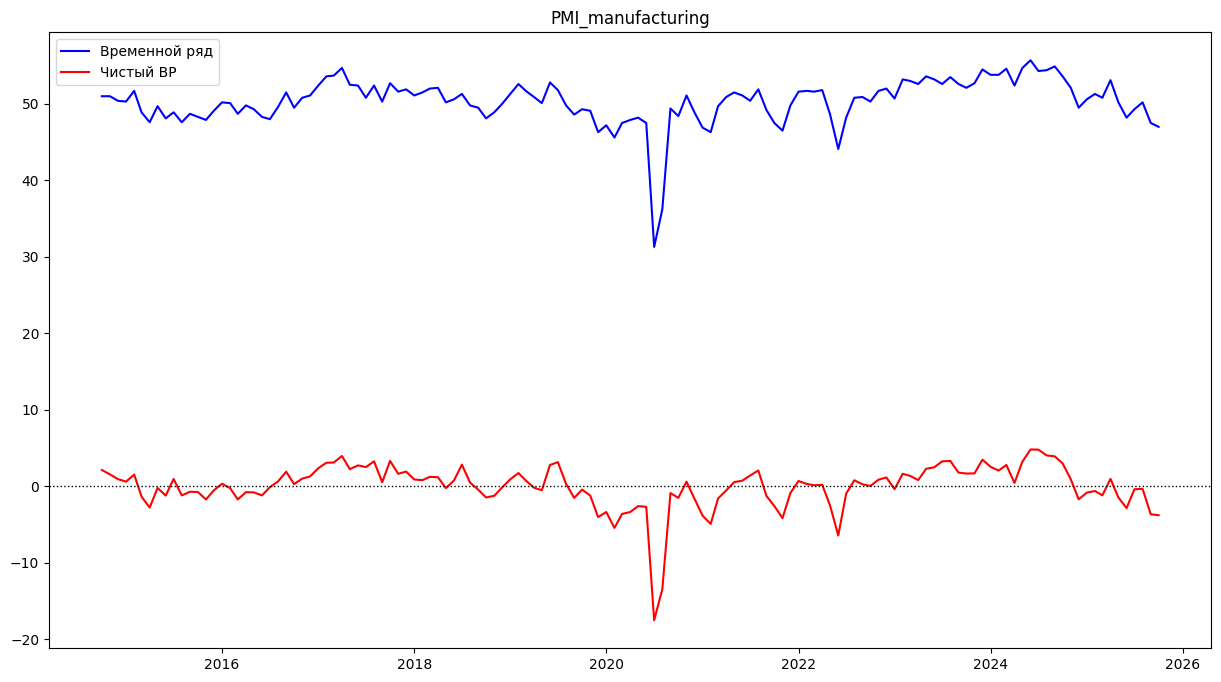

Исходный ряд PMI_manufacturing оказался стационарным


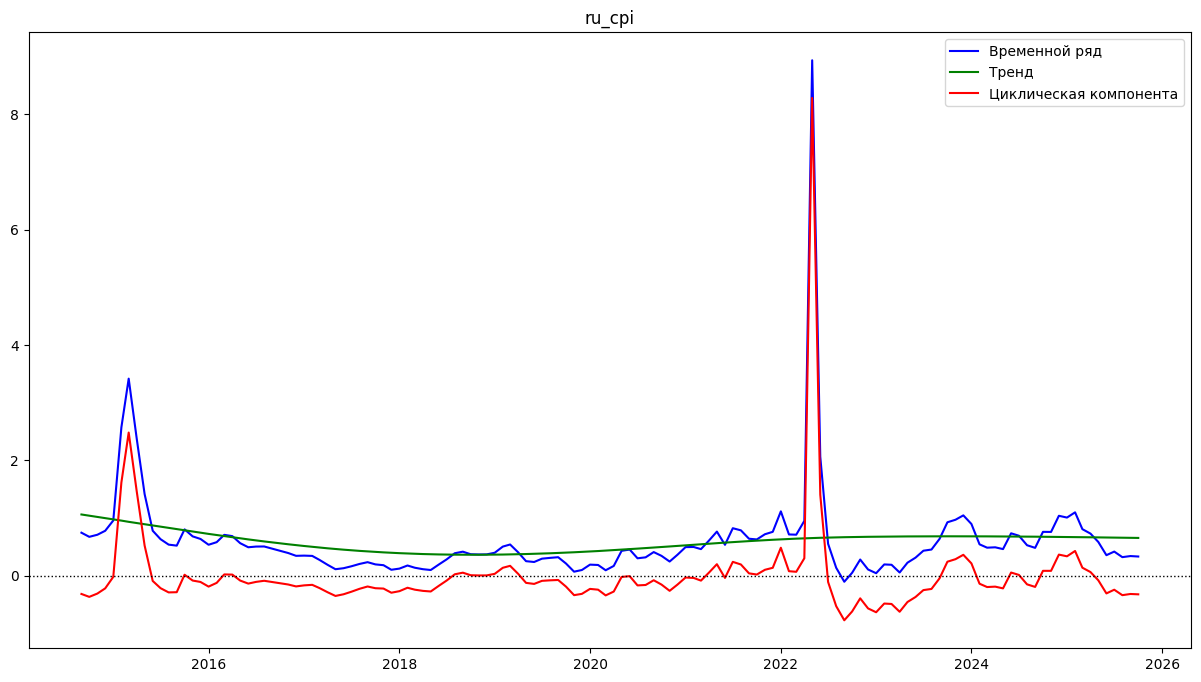

Исходный ряд ru_cpi оказался стационарным


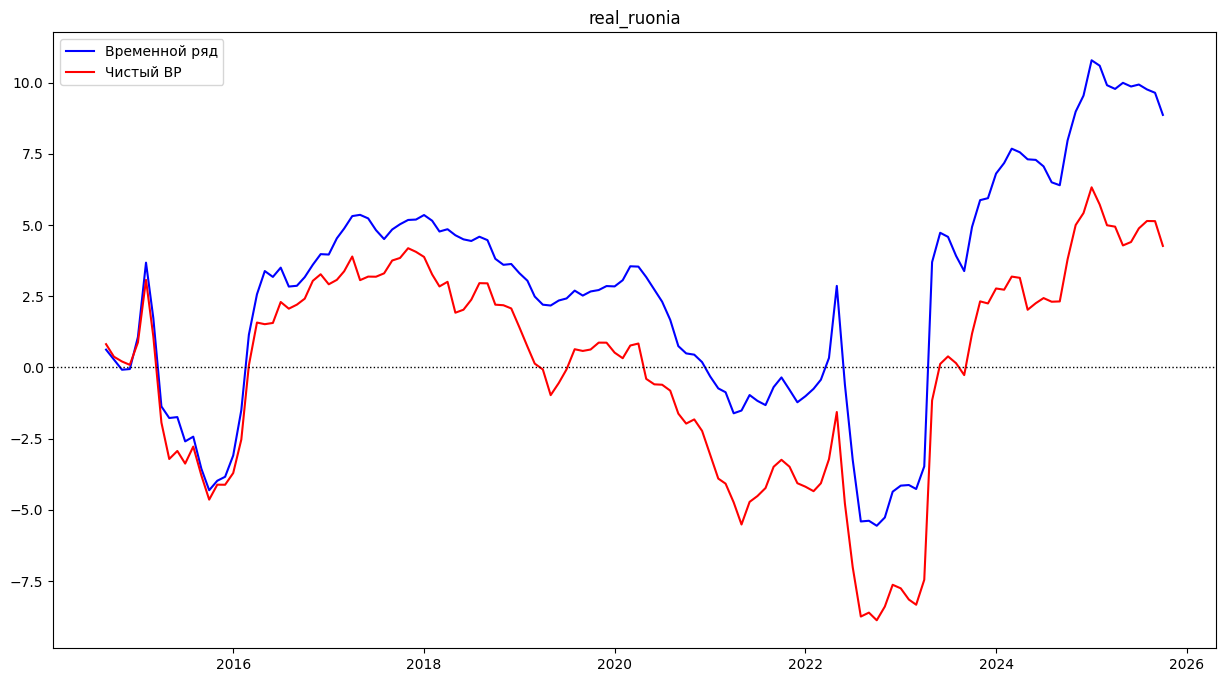

Исходный ряд real_ruonia оказался стационарным


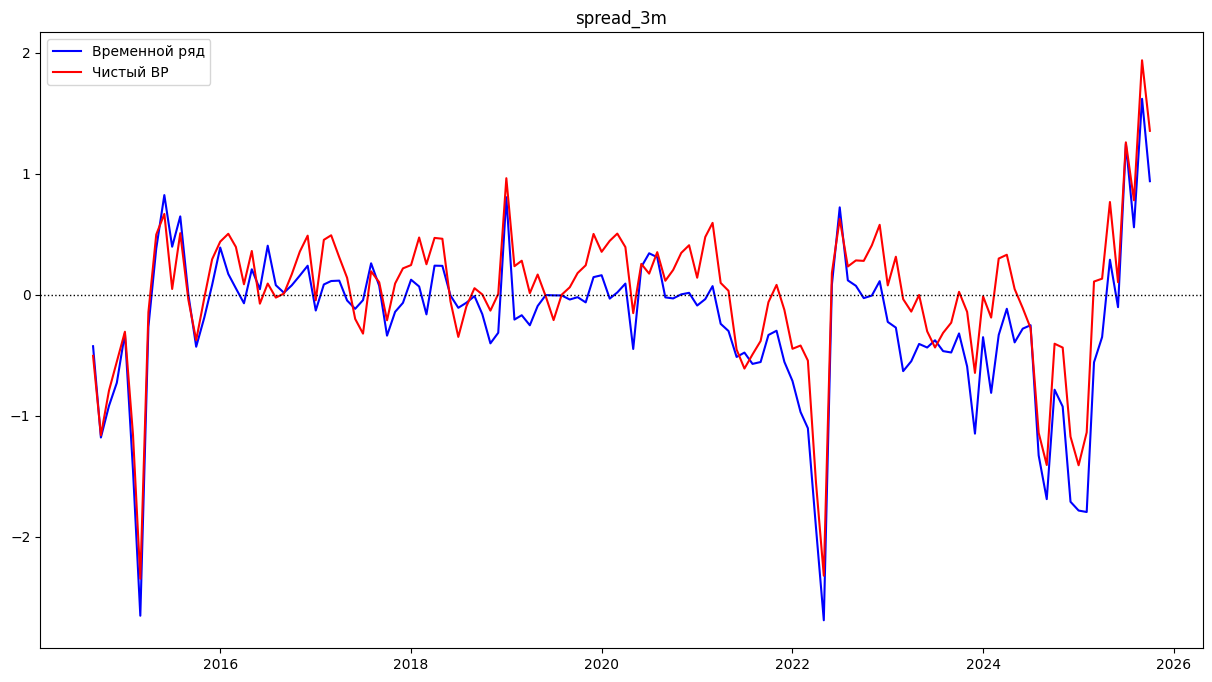

Исходный ряд spread_3m оказался стационарным


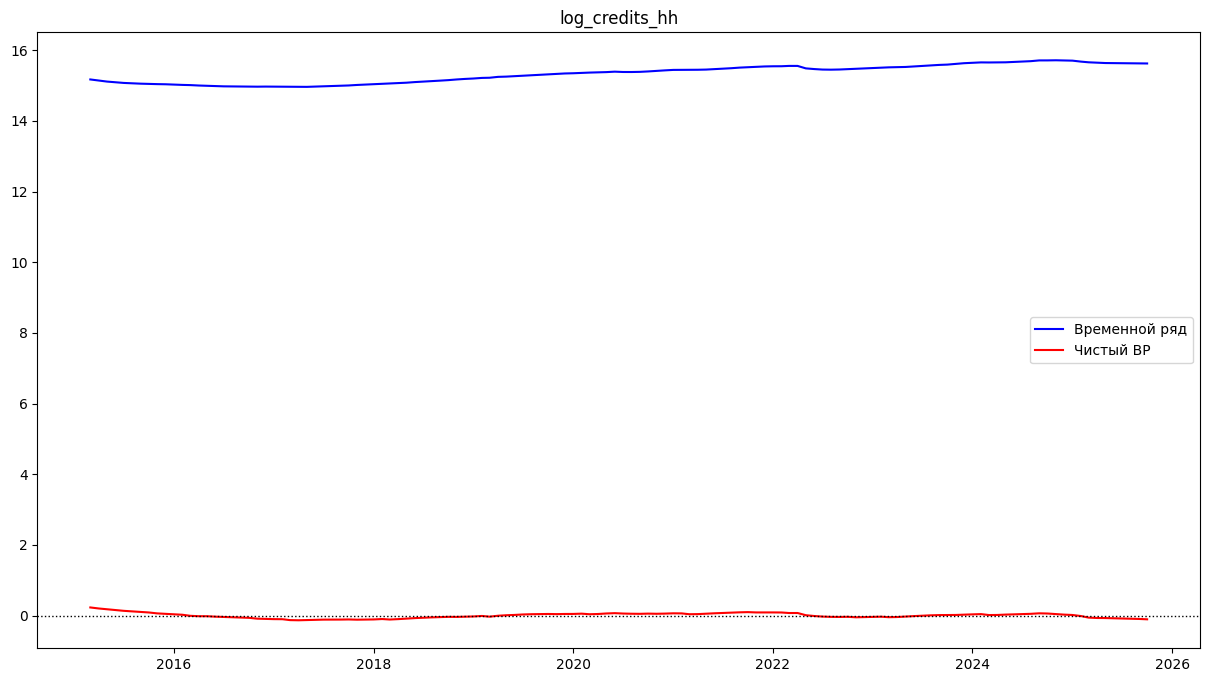

Исходный ряд log_credits_hh оказался стационарным


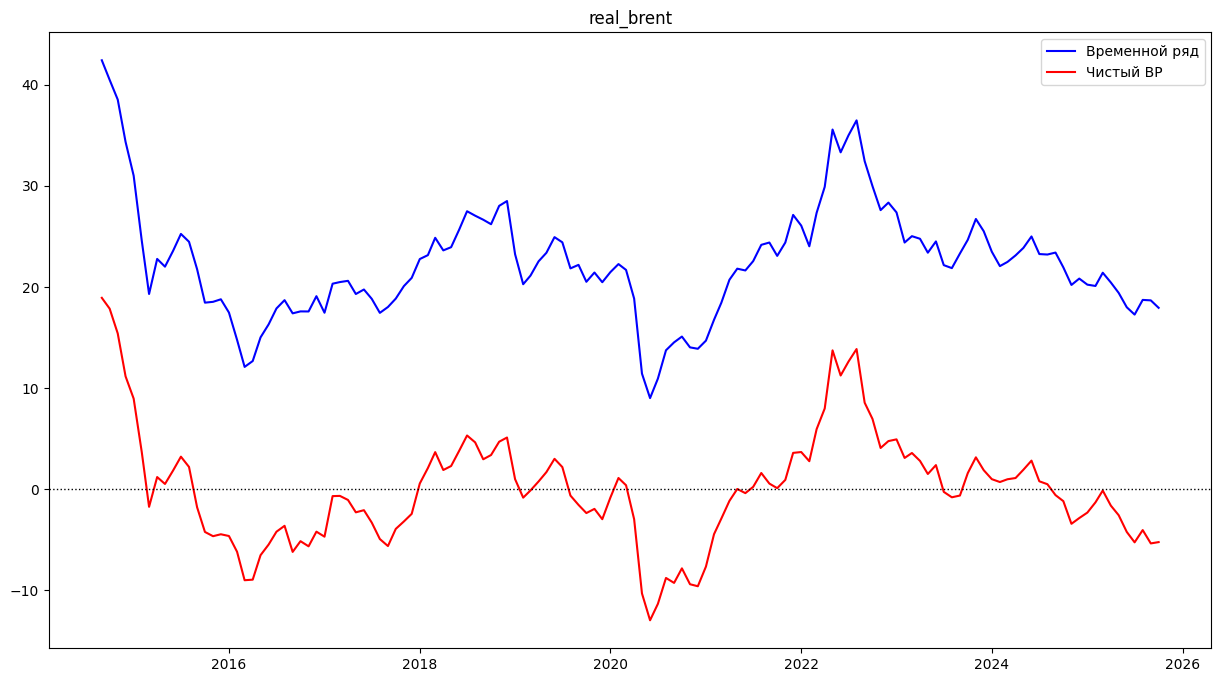

Исходный ряд real_brent оказался стационарным
Обрати внимание, что для переменной var_name есть пробел в данных
между 73 и 68 наблюдениями длинной больше 2


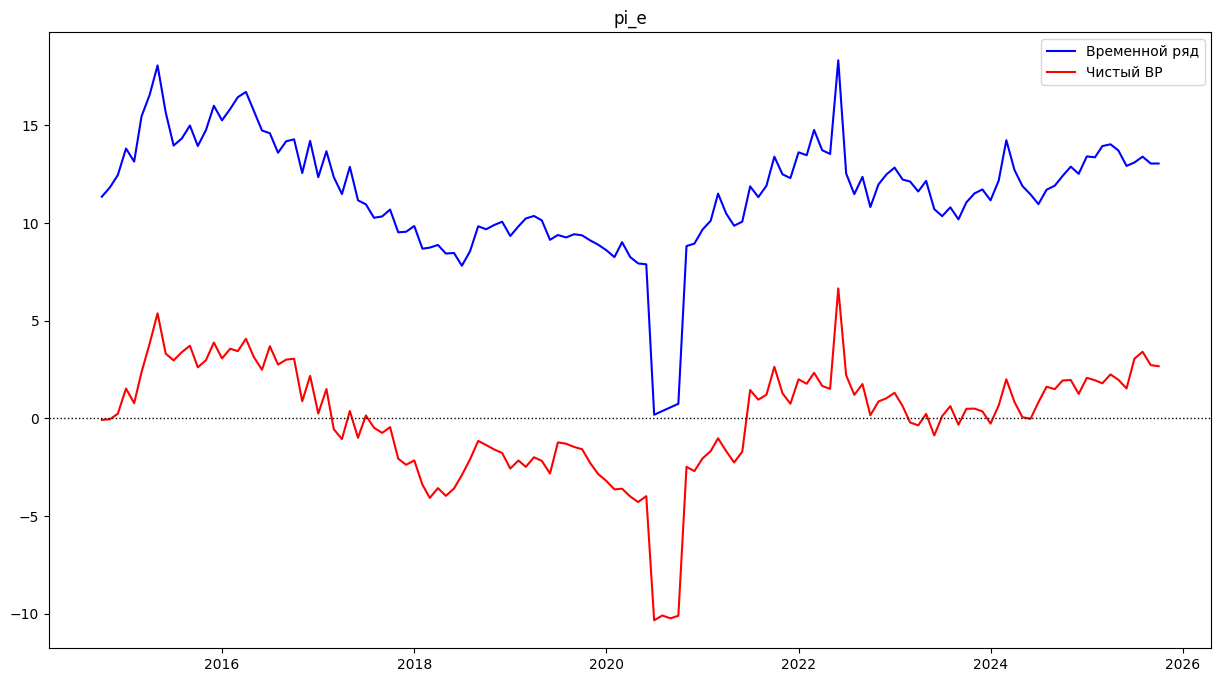

Исходный ряд pi_e оказался стационарным


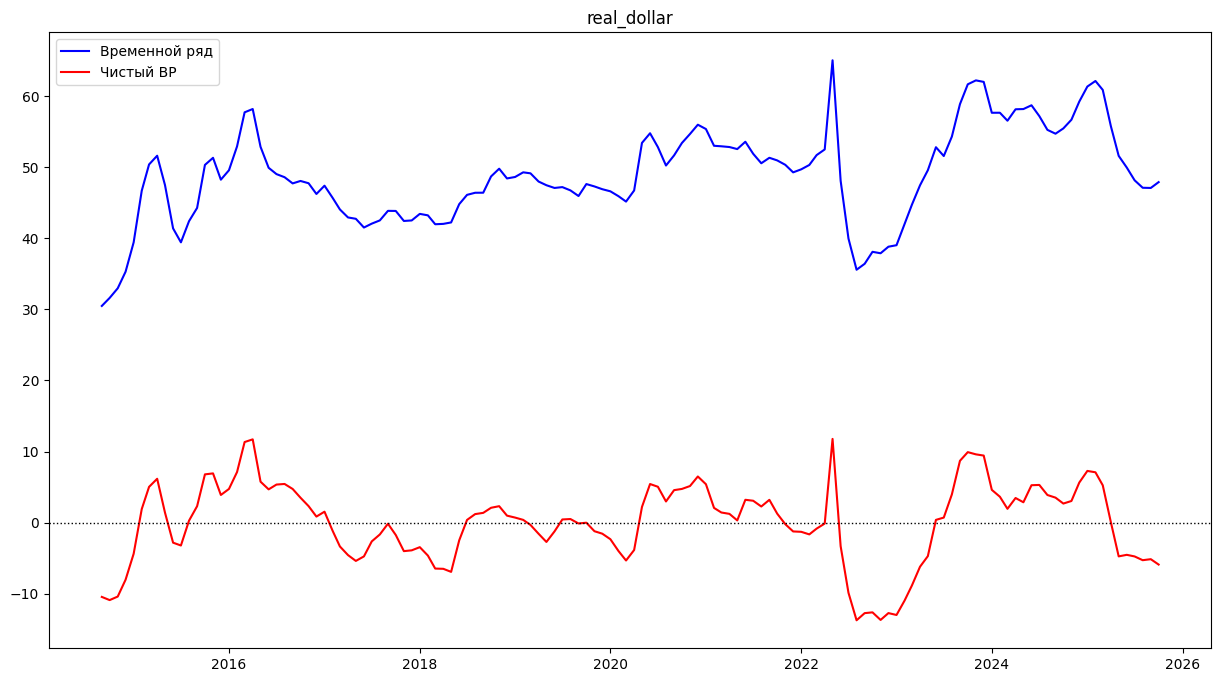

Исходный ряд real_dollar оказался стационарным


In [4]:
df, data = var_spec.LOS(use_harmonics=False, only_KPSS = True, hp_filter_map={
                                                                               'ru_cpi': True,
                                                                               'real_rate': False,
                                                                               'm2x_sa_mom': True})
covid_start, duration_covid = (data.T.index < dt(2020, 3, 1)).sum(), 5
svo_start, svo_duration = (data.T.index < dt(2022, 2, 1)).sum(), 2

data = data.T.sort_index(ascending=False).T.copy(deep=True)
data.loc['covid', :] = np.concatenate([np.zeros(data.shape[1]-covid_start-duration_covid), np.ones(duration_covid), np.zeros(covid_start)])
#data.loc['svo', :] = np.concatenate([np.zeros(svo_start), np.ones(svo_duration), np.zeros(data.shape[1]-svo_start-svo_duration)])
data = data.copy(deep = True)
data.loc['pi_e', (data.T.index > dt(2020, 3, 1)) & (data.T.index < dt(2020, 8, 1))] = data.loc['pi_e', (data.T.index > dt(2020, 3, 1)) & (data.T.index < dt(2020, 8, 1))].copy() +7

In [5]:
data

2025-07-01  2025-06-01  2025-05-01  2025-04-01  2025-03-01  \
PMI_manufacturing   -3.774797   -3.652846   -0.325573   -0.380118   -2.852846   
ru_cpi              -0.316267   -0.336867   -0.242479   -0.306467   -0.079319   
real_ruonia          5.139010    5.143301    4.884079    4.405812    4.285440   
spread_3m            1.939135    0.781193    1.260428    0.103590    0.766973   
log_credits_hh      -0.096406   -0.086346   -0.082164   -0.077051   -0.071438   
real_brent          -5.360678   -4.041552   -5.252878   -4.225030   -2.571564   
pi_e                 2.669904    2.727138    3.410845    3.054134    1.532012   
real_dollar         -5.124815   -5.266979   -4.738461   -4.511481   -4.729992   
covid                0.000000    0.000000    0.000000    0.000000    0.000000   

                   2025-02-01  2025-01-01  2024-12-01  2024-11-01  2024-10-01  \
PMI_manufacturing   -1.452846    0.974427   -1.180118   -0.607391   -0.825573   
ru_cpi               0.063876    0.139209    0.429199    0.336873    0.366330   
real_ruonia          4.945069    4.993970    5.720970    6.326494    5.423112   
spread_3m            0.132983    0.109144   -1.138161   -1.410217   -1.173754   
log_credits_hh      -0.069534   -0.058733   -0.014818    0.015449    0.025838   
real_brent          -1.623382   -0.133063   -1.301953   -2.312713   -2.852753   
pi_e                 1.975485    2.249895    1.794832    1.951530    2.076625   
real_dollar          0.083156    5.262579    7.092760    7.285166    5.644690   
covid                0.000000    0.000000    0.000000    0.000000    0.000000   

                   ...  2015-10-01  2015-09-01  2015-08-01  2015-07-01  \
PMI_manufacturing  ...    0.342276   -0.521360   -1.712269   -0.732742   
ru_cpi             ...   -0.107753   -0.083392    0.017495   -0.285386   
real_ruonia        ...   -4.118169   -4.116047   -4.640636   -3.789260   
spread_3m          ...    0.292986   -0.027083   -0.375508   -0.040789   
log_credits_hh     ...    0.048007    0.060690    0.086936    0.100444   
real_brent         ...   -4.454908   -4.645519   -4.225194   -1.787567   
pi_e               ...    3.067810    3.883423    2.980463    2.615503   
real_dollar        ...    3.903410    6.937763    6.801027    2.327151   
covid              ...    0.000000    0.000000    0.000000    0.000000   

                   2015-06-01  2015-05-01  2015-04-01  2015-03-01  2015-02-01  \
PMI_manufacturing   -0.710791   -1.183518    0.961936   -1.210791   -0.210791   
ru_cpi              -0.288914   -0.215638   -0.090351    0.523149    1.455597   
real_ruonia         -2.778621   -3.375363   -2.931969   -3.213705   -1.933132   
spread_3m            0.509296    0.047805    0.668311    0.497733   -0.144377   
log_credits_hh       0.117438    0.133447    0.152520    0.177083    0.199646   
real_brent           2.202691    3.218217    1.849377    0.518234    1.201854   
pi_e                 3.720581    3.388204    2.968513    3.313873    5.380410   
real_dollar          0.288980   -3.200444   -2.802542    1.421163    6.182079   
covid                0.000000    0.000000    0.000000    0.000000    0.000000   

                   2015-01-01  
PMI_manufacturing   -2.783518  
ru_cpi               2.482129  
real_ruonia          1.089285  
spread_3m           -2.348797  
log_credits_hh       0.228935  
real_brent          -1.742689  
pi_e                 3.836426  
real_dollar          5.043736  
covid                0.000000  

[9 rows x 127 columns]

In [6]:
lag, lag_ex = 4, 1

Z, Y, B_hat, E, K, T, B_hat_endo, P = OLS_estimation( # type: ignore
    data.loc[[
    'PMI_manufacturing',
    'ru_cpi',
    'real_ruonia',
    'real_dollar',
    'pi_e'
       
], :], 
    lag = lag, 
    exog_data = data.loc[[
    'real_brent'
], :],  # type: ignore
    lag_exog=lag_ex)
K_endo, K_exog = P.shape[0], B_hat.shape[1] - K*lag - 1
u_dict = {0: 'шок AS',
          1: 'шок AD',
          2: 'шок ДКП',
          3: 'шок спроса на валюту',
          4: 'шок ИО'}
y_dict = {0: 'выпуск',
          1: 'инфляция',
          2: 'реальная RUONIA',
          3: 'реальный курс доллара',
          4: 'инфляционные ожидания'}


data_endo = data.loc[[
    'PMI_manufacturing',
    'ru_cpi',
    'real_ruonia',
    'real_dollar',
    'pi_e']].copy(deep=True)
data_endo = data_endo.rename(index = {k:v for k, v in zip(data_endo.index.to_list(),[i for i in y_dict.values()])})

Найдено матриц: 1000/1000 (100.0%), Использовано симуляций: 1000
Параметр жесткости 100.00%
[0, 2]


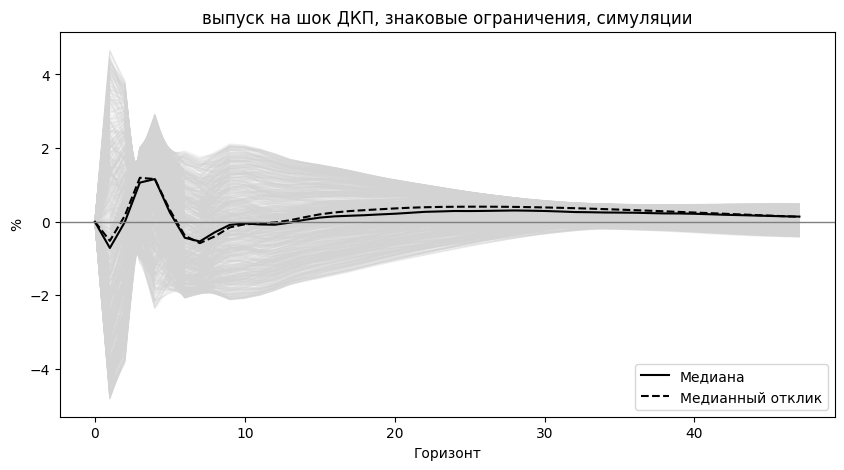

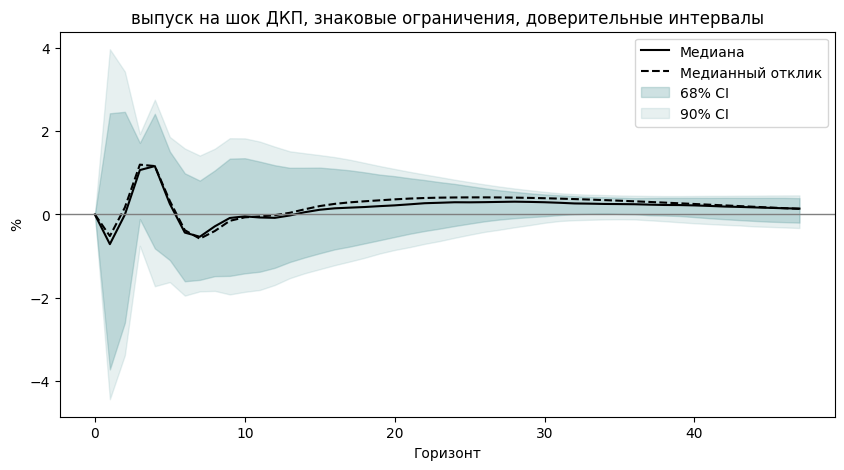

Вероятность, что суммарный отклик положительный 0.66, горизонт 48 мес.
Медианный суммарный отклик  7.76182, горизонт 48 мес.
Верхние 95% суммарный отклик  51.48767, горизонт 48 мес.
Нижние 5% суммарный отклик  -42.41545, горизонт 48 мес.
[0, 3]


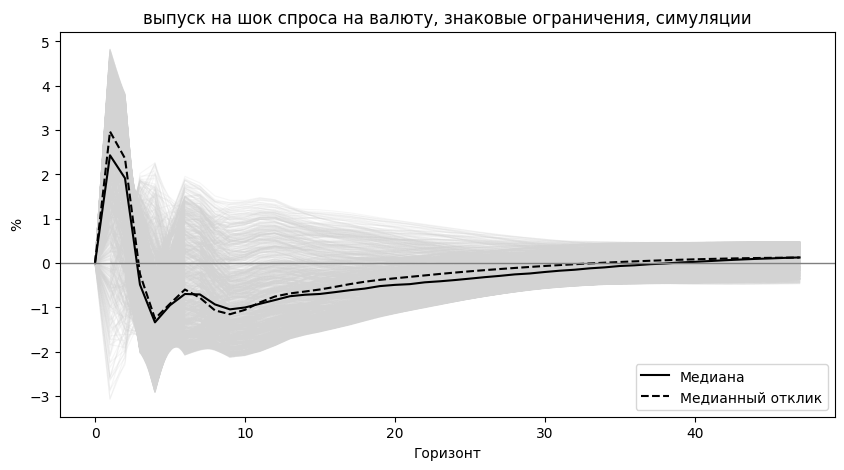

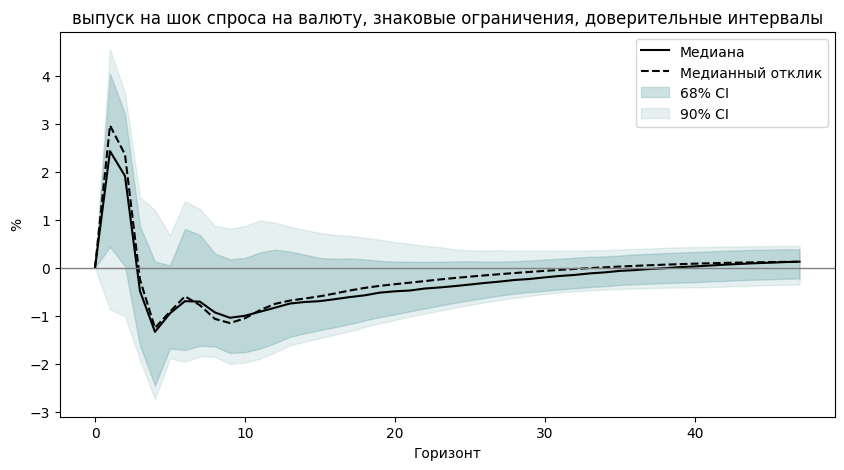

Вероятность, что суммарный отклик положительный 0.215, горизонт 48 мес.
Медианный суммарный отклик  -12.92749, горизонт 48 мес.
Верхние 95% суммарный отклик  35.053, горизонт 48 мес.
Нижние 5% суммарный отклик  -47.30919, горизонт 48 мес.
[0, 4]


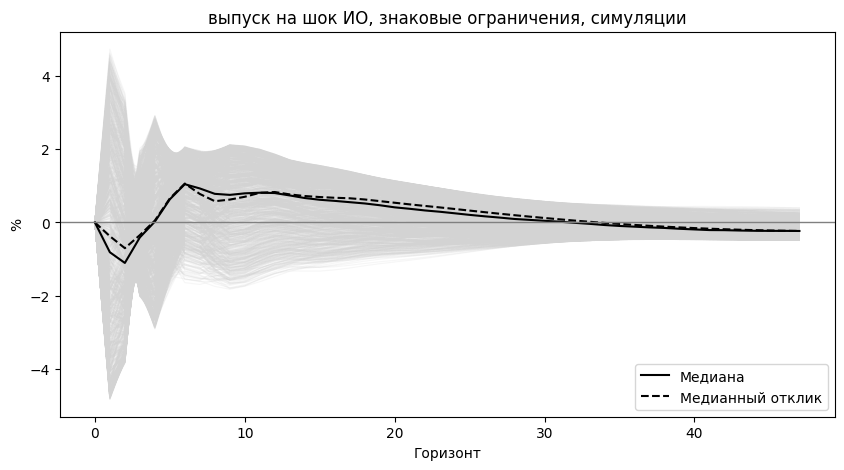

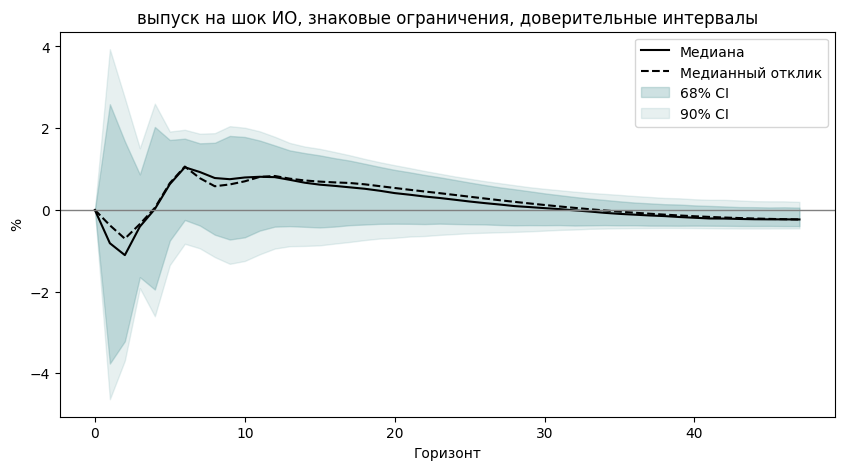

Вероятность, что суммарный отклик положительный 0.656, горизонт 48 мес.
Медианный суммарный отклик  8.20339, горизонт 48 мес.
Верхние 95% суммарный отклик  49.76432, горизонт 48 мес.
Нижние 5% суммарный отклик  -41.54355, горизонт 48 мес.
[1, 2]


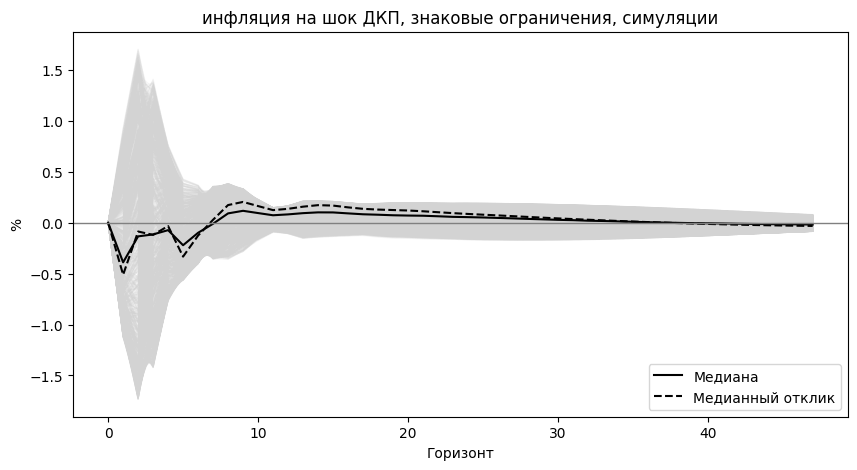

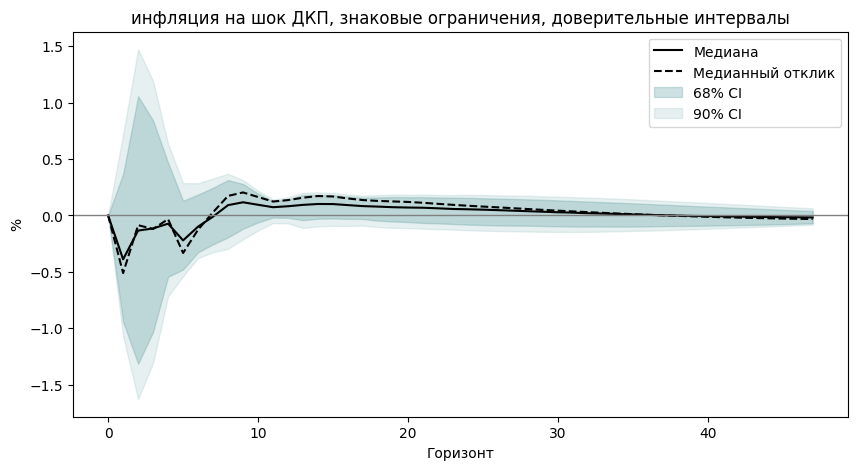

Вероятность, что суммарный отклик отрицательный 0.463, горизонт 48 мес.
Медианный суммарный отклик  0.57447, горизонт 48 мес.
Верхние 95% суммарный отклик  11.37519, горизонт 48 мес.
Нижние 5% суммарный отклик  -10.93237, горизонт 48 мес.
[1, 3]


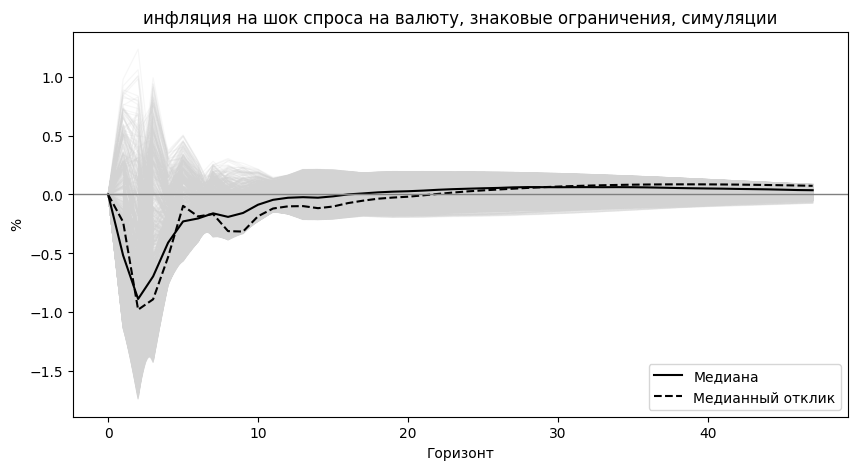

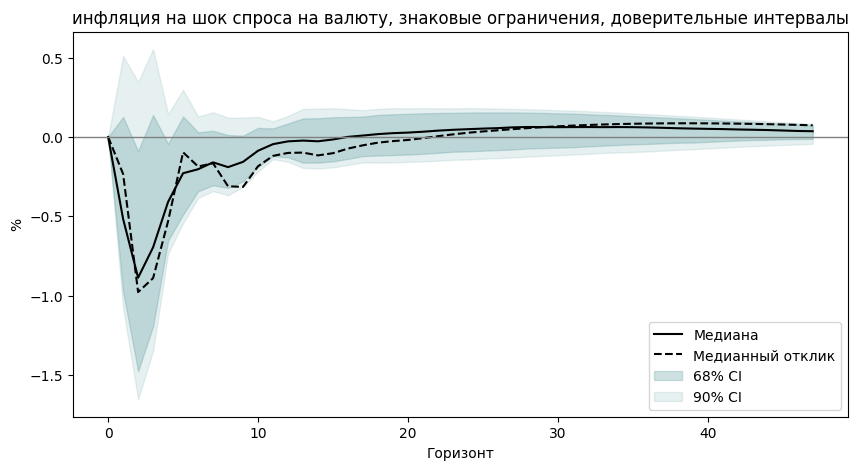

Вероятность, что суммарный отклик отрицательный 0.742, горизонт 48 мес.
Медианный суммарный отклик  -2.18682, горизонт 48 мес.
Верхние 95% суммарный отклик  8.06925, горизонт 48 мес.
Нижние 5% суммарный отклик  -11.32389, горизонт 48 мес.
[1, 4]


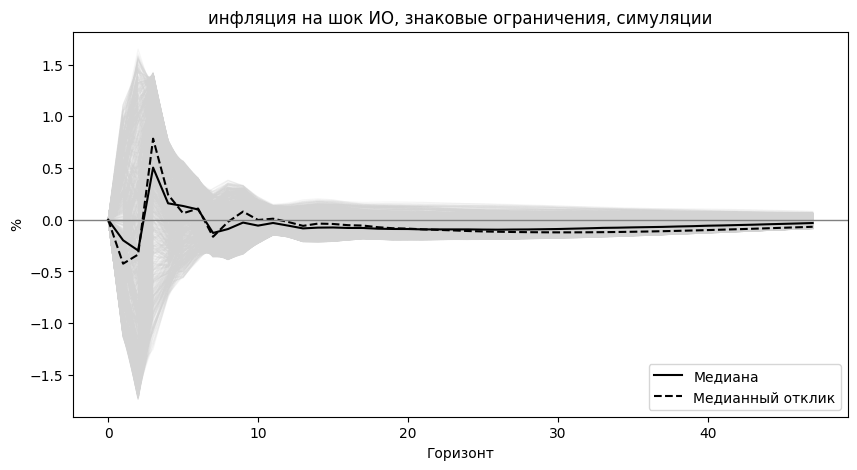

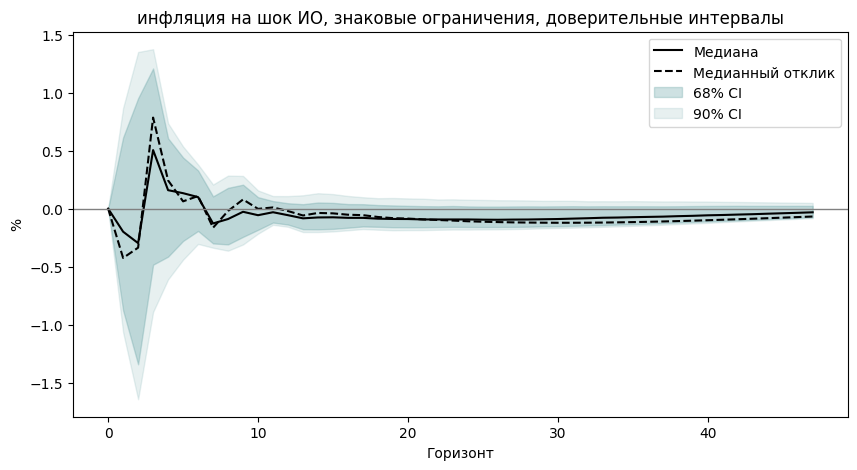

Вероятность, что суммарный отклик отрицательный 0.745, горизонт 48 мес.
Медианный суммарный отклик  -2.61648, горизонт 48 мес.
Верхние 95% суммарный отклик  8.98649, горизонт 48 мес.
Нижние 5% суммарный отклик  -11.90802, горизонт 48 мес.
[2, 2]


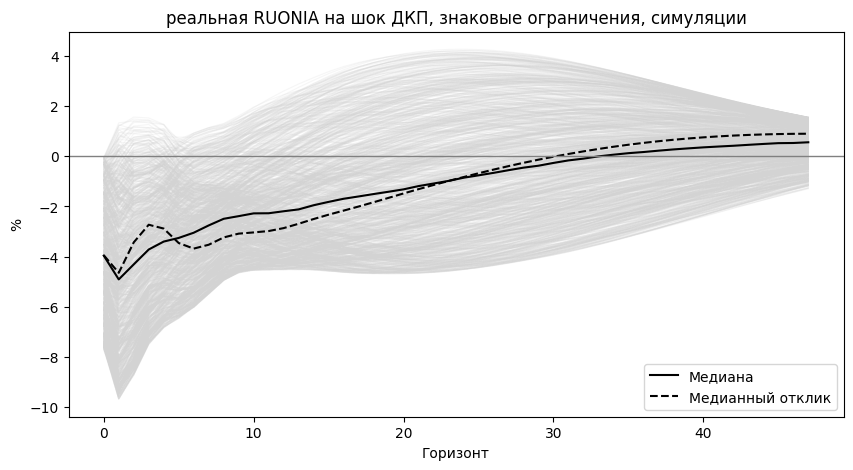

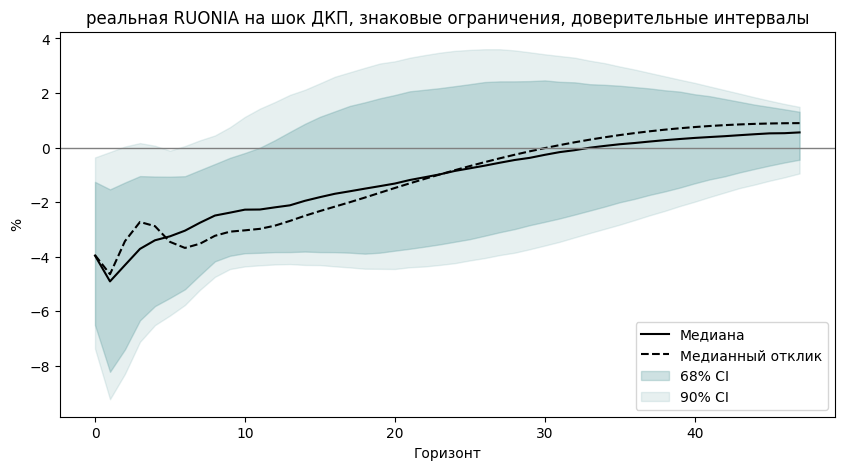

Вероятность, что суммарный отклик положительный 0.268, горизонт 48 мес.
Медианный суммарный отклик  -57.0103, горизонт 48 мес.
Верхние 95% суммарный отклик  103.15641, горизонт 48 мес.
Нижние 5% суммарный отклик  -190.23004, горизонт 48 мес.
[2, 3]


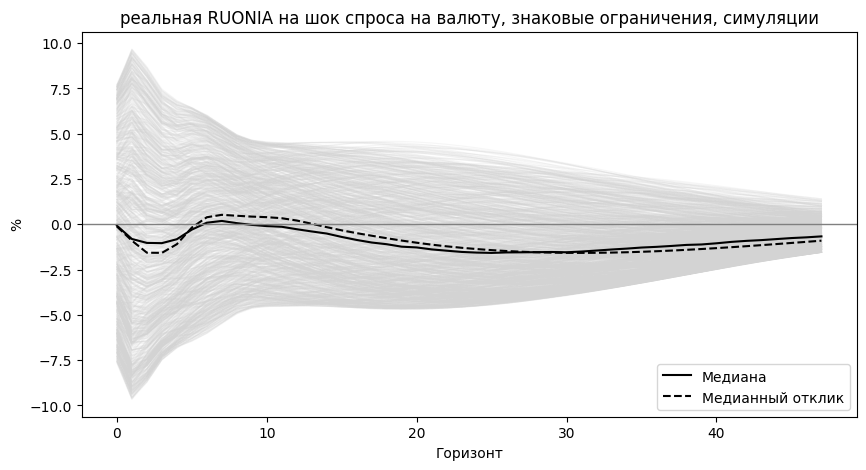

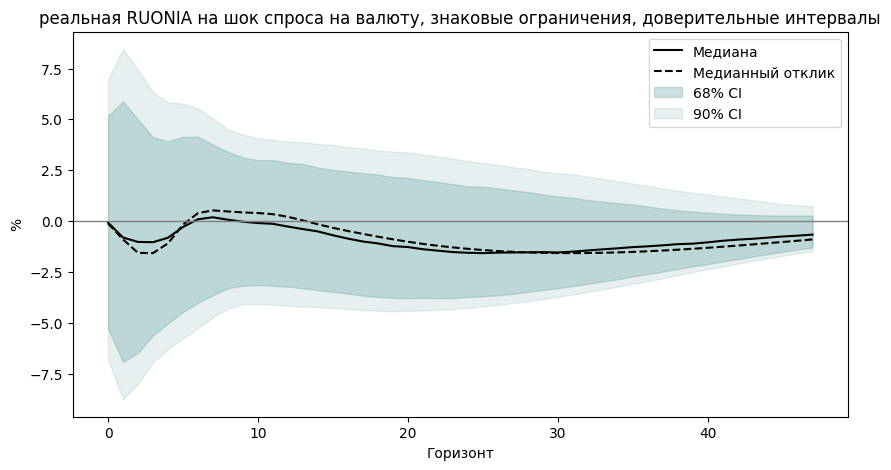

Вероятность, что суммарный отклик положительный 0.365, горизонт 48 мес.
Медианный суммарный отклик  -45.04557, горизонт 48 мес.
Верхние 95% суммарный отклик  153.6276, горизонт 48 мес.
Нижние 5% суммарный отклик  -192.37339, горизонт 48 мес.
[2, 4]


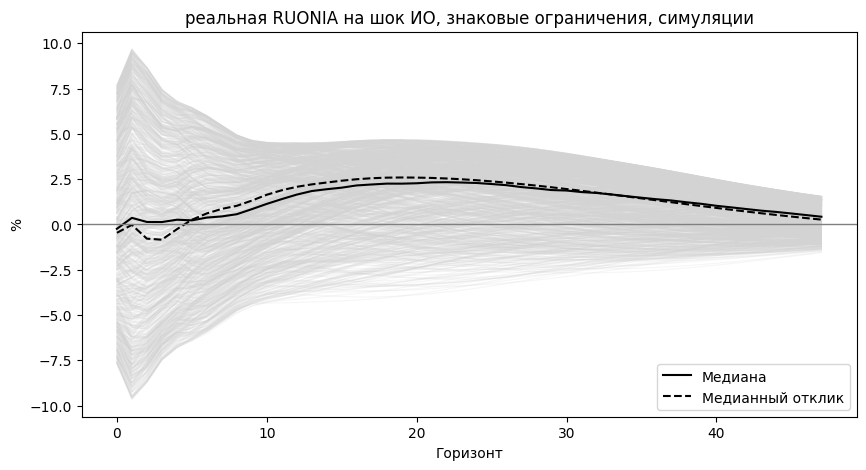

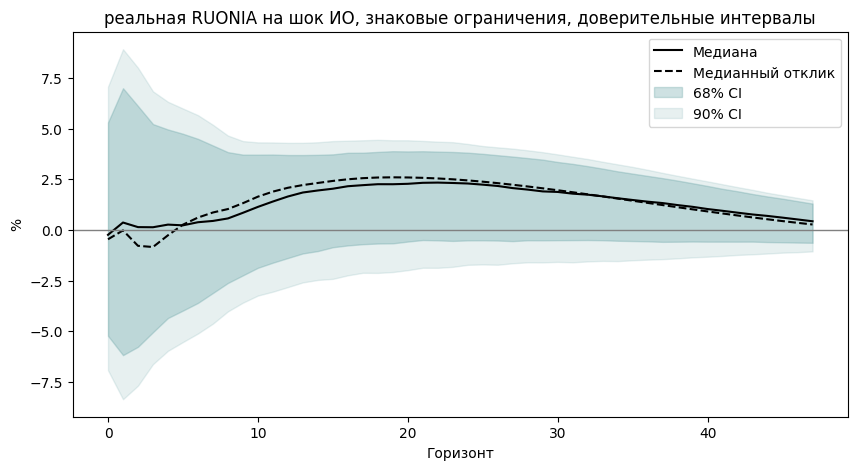

Вероятность, что суммарный отклик положительный 0.731, горизонт 48 мес.
Медианный суммарный отклик  64.89283, горизонт 48 мес.
Верхние 95% суммарный отклик  195.14886, горизонт 48 мес.
Нижние 5% суммарный отклик  -125.46178, горизонт 48 мес.
[3, 2]


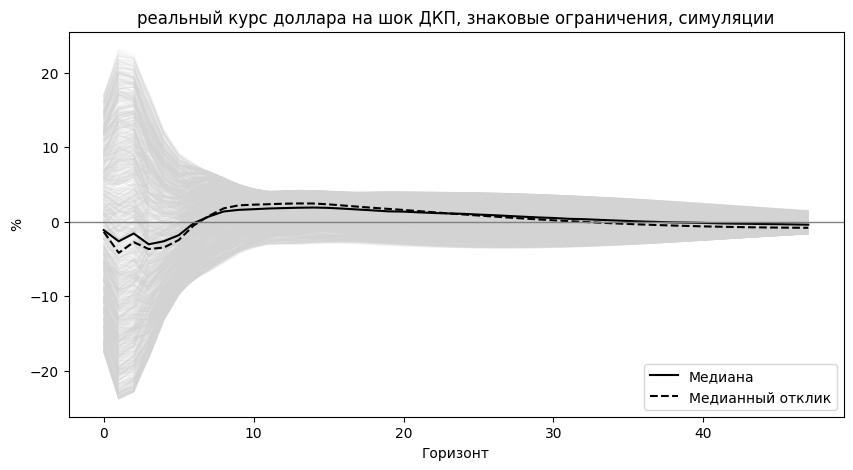

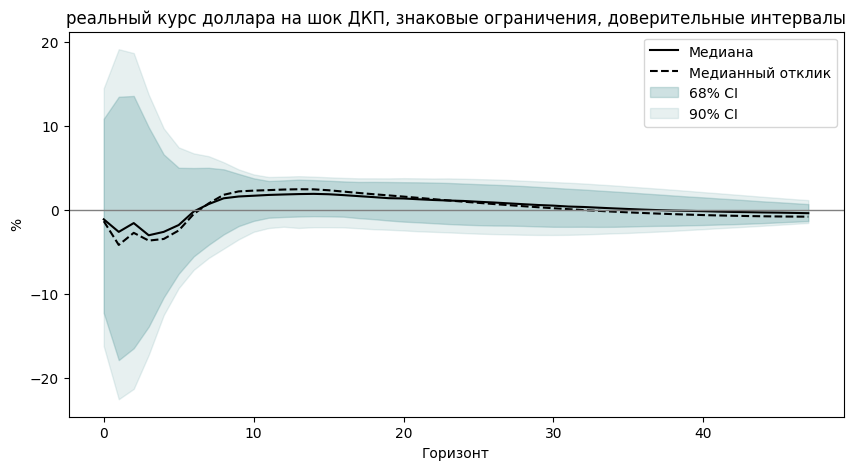

Вероятность, что суммарный отклик положительный 0.55, горизонт 48 мес.
Медианный суммарный отклик  16.79, горизонт 48 мес.
Верхние 95% суммарный отклик  223.17905, горизонт 48 мес.
Нижние 5% суммарный отклик  -213.06076, горизонт 48 мес.
[3, 3]


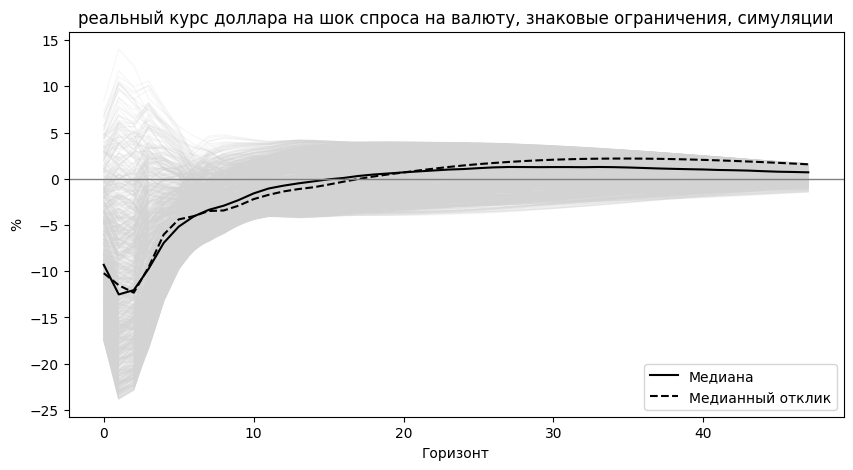

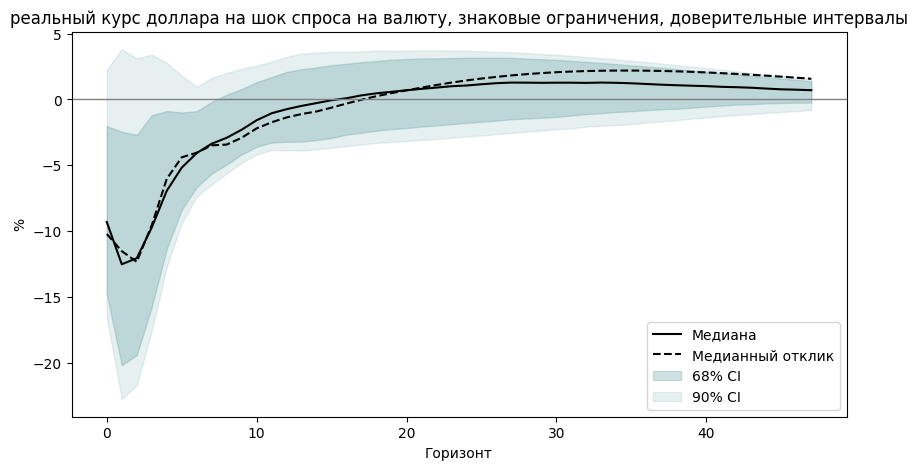

Вероятность, что суммарный отклик положительный 0.275, горизонт 48 мес.
Медианный суммарный отклик  -41.63309, горизонт 48 мес.
Верхние 95% суммарный отклик  139.68854, горизонт 48 мес.
Нижние 5% суммарный отклик  -216.67066, горизонт 48 мес.
[3, 4]


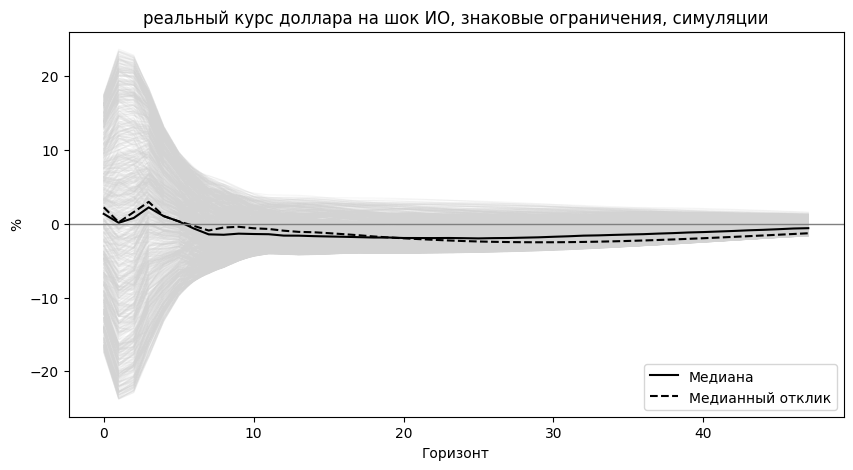

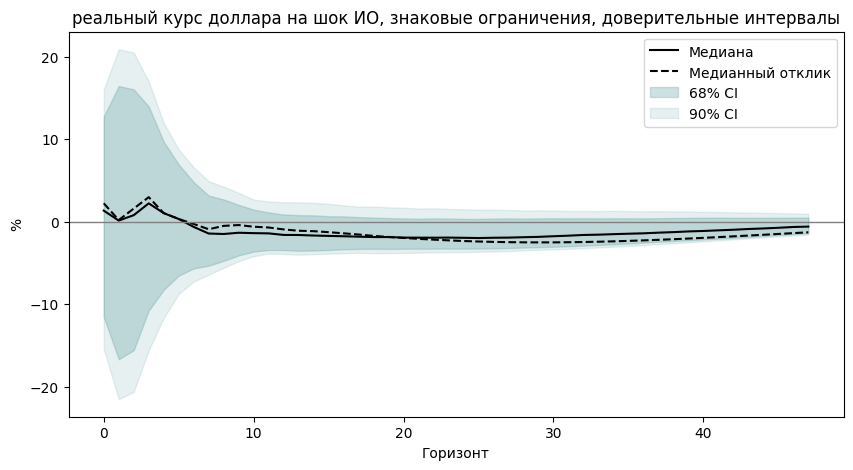

Вероятность, что суммарный отклик положительный 0.243, горизонт 48 мес.
Медианный суммарный отклик  -56.56998, горизонт 48 мес.
Верхние 95% суммарный отклик  172.44611, горизонт 48 мес.
Нижние 5% суммарный отклик  -238.06186, горизонт 48 мес.
[4, 2]


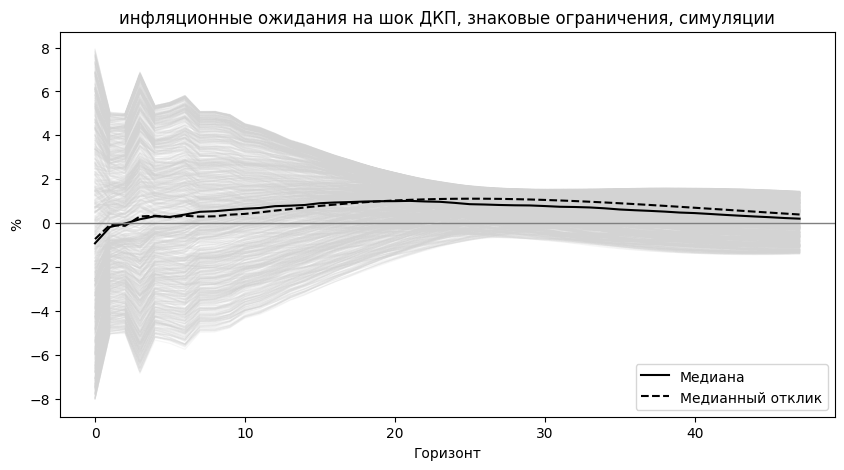

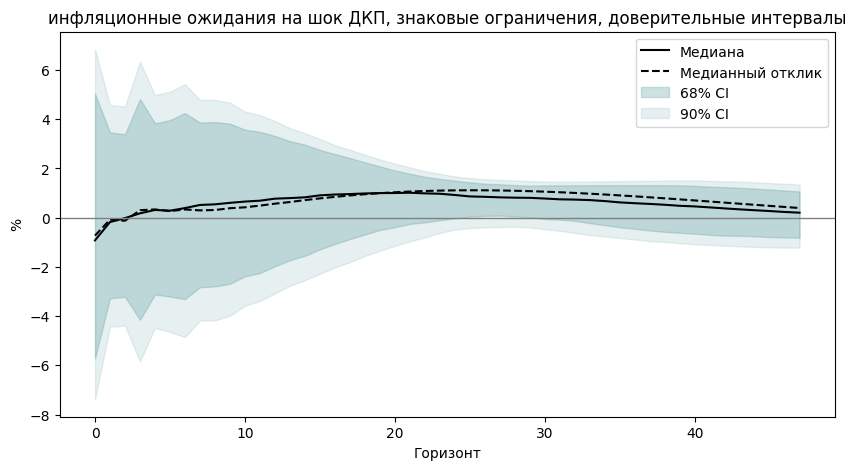

Вероятность, что суммарный отклик положительный 0.708, горизонт 48 мес.
Медианный суммарный отклик  28.22337, горизонт 48 мес.
Верхние 95% суммарный отклик  128.82784, горизонт 48 мес.
Нижние 5% суммарный отклик  -95.81829, горизонт 48 мес.
[4, 3]


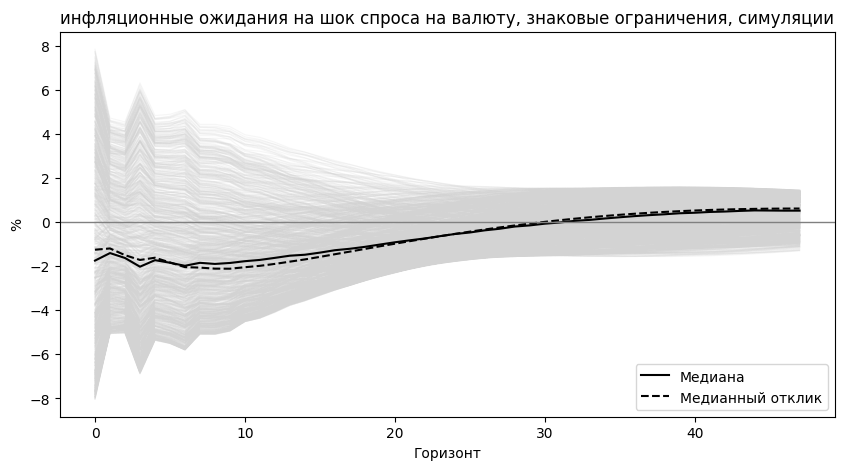

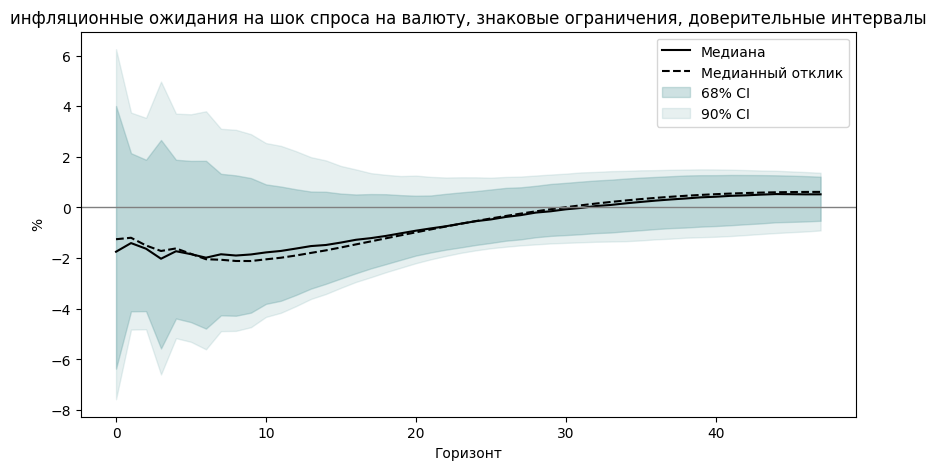

Вероятность, что суммарный отклик положительный 0.288, горизонт 48 мес.
Медианный суммарный отклик  -31.52565, горизонт 48 мес.
Верхние 95% суммарный отклик  95.02919, горизонт 48 мес.
Нижние 5% суммарный отклик  -125.99079, горизонт 48 мес.
[4, 4]


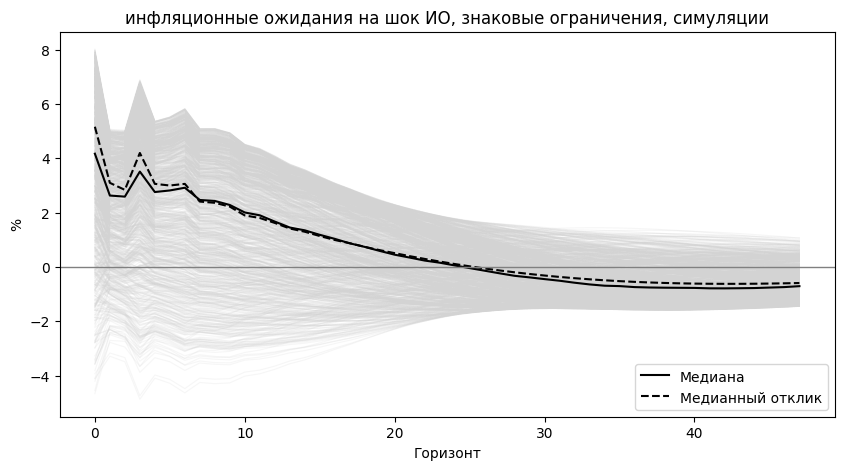

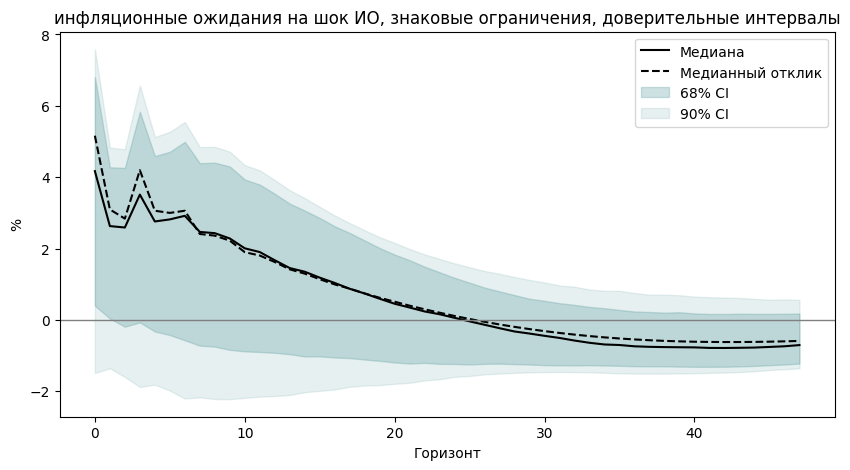

Вероятность, что суммарный отклик положительный 0.692, горизонт 48 мес.
Медианный суммарный отклик  28.75978, горизонт 48 мес.
Верхние 95% суммарный отклик  116.02089, горизонт 48 мес.
Нижние 5% суммарный отклик  -81.50193, горизонт 48 мес.


In [7]:
pluses0 = [
    [], []
]
minuses0 = [
    [], []
]
pluses1 = [
    [], []
]
minuses1 = [
    [], []
]
plus_spec = [
    
]
minus_spec = [

]
pluses0= [(np.array(pluses0[0])-1).tolist(), (np.array(pluses0[1])-1).tolist()]
pluses1 = [(np.array(pluses1[0])-1).tolist(), (np.array(pluses1[1])-1).tolist()]
minuses0 = [(np.array(minuses0[0])-1).tolist(), (np.array(minuses0[1])-1).tolist()]
minuses1 = [(np.array(minuses1[0])-1).tolist(), (np.array(minuses1[1])-1).tolist()]

import sys

required = 1000
np.random.seed(10)
A_mats = B_hat_endo[:, 1:]
lag = int((A_mats.shape[1])/K)

# Companion matrix

bottom = np.eye(K*(lag-1), K*lag)
A_comp = np.vstack([A_mats, bottom])

# Selector
J = np.hstack([np.eye(K), np.zeros((K, K*(lag-1)))])

# number of negative and positive sign restrictions
trans_matrix = np.identity(K)
#trans_matrix[2,3] = 1
#trans_matrix[2,2] = 1
#trans_matrix[3,3] = 1
i = 0
sim = 0
accepted = []
while len(accepted) < required:

    Q = np.identity(K)
    Q_k = random_orthogonal(3)
    Q[2:, 2:] = Q_k

    
    B_inv = P@ trans_matrix @Q
    irf1 = J @ A_comp @ J.T @ B_inv
    irf2 = J @ np.linalg.matrix_power(A_comp, 2) @ J.T @ B_inv
    irf3 = J @ np.linalg.matrix_power(A_comp, 3) @ J.T @ B_inv
    irf4 = J @ np.linalg.matrix_power(A_comp, 4) @ J.T @ B_inv
    cond1 = np.sum(irf1[pluses1[0], pluses1[1]].flatten() > 0) == len(pluses1[0])  and np.sum(irf1[minuses1[0], minuses1[1]].flatten() < 0) == len(minuses1[0])
    cond2 = np.sum(irf2[pluses1[0], pluses1[1]].flatten() > 0) == len(pluses1[0])  and np.sum(irf2[minuses1[0], minuses1[1]].flatten() < 0) == len(minuses1[0])
    cond0 = np.sum(B_inv[pluses0[0], pluses0[1]].flatten() > 0) == len(pluses0[0]) and np.sum(B_inv[minuses0[0], minuses0[1]].flatten() < 0) == len(minuses0[0])

    irf_c1_4 = irf1 + irf2 + irf3 + irf4
    cond_spec_1_4_plus = np.array([irf_c1_4[r, s] > 0 for r, s in plus_spec]).sum() == len(plus_spec)
    cond_spec_1_4_minus = np.array([irf_c1_4[r, s] < 0 for r, s in minus_spec]).sum() == len(minus_spec)
    if cond0 and cond1 and cond2 and cond_spec_1_4_plus and cond_spec_1_4_minus:
        accepted.append(Q)
        i += 1
    sim += 1
    sys.stdout.write(f"\rНайдено матриц: {i}/{required} ({i*100/required:.1f}%), Использовано симуляций: {sim}")
    sys.stdout.flush()

print(f'\nПараметр жесткости {required*100/sim:.2f}%')
horizon = 48
IRF = []
for Q in accepted:
    IRF.append(irf_companion(B_hat_endo[:, 1:], P@trans_matrix@Q, horizon))
    

for i, j in [(i, j) for i in range(K_endo) for j in range(2, K_endo)]:
    irf = IRF[0]
    response = [i, j]
    print(response)
    virf = irf[:, response[0], response[1]]
    
    for irf in IRF[1:]:
        virf = np.vstack([virf, irf[:, response[0], response[1]]])
    median_index = pd.DataFrame((virf - np.median(virf, axis = 0))**2).sum(1).sort_values().index[0]
    import matplotlib.pyplot as plt

    # Имитация матрицы: 10000 симуляций × 20 шагов
    np.random.seed(0)
    responses = virf
    rescale = False
    if rescale:
        depend = data.iloc[response[0]].std()
        shock = data.iloc[response[1]].std()
        virf *= shock/depend
    # Квантили
    if j == 2:
        sign = 1
    else:
        sign = 1
    median = sign*np.percentile(responses, 50, axis=0)
    lower68 = sign*np.percentile(responses, 16, axis=0)
    upper68 = sign*np.percentile(responses, 84, axis=0)
    lower90 = sign*np.percentile(responses, 5, axis=0)
    upper90 = sign*np.percentile(responses, 95, axis=0)
    med_res = sign*virf[median_index, :]
    median_s = median.sum()
    upper90_s = upper90.sum()
    # Горизонты
    x_axis = np.arange(horizon)
    plt.figure(figsize=(10,5))
    plt.plot(x_axis, virf.T, color="lightgray", alpha=0.2, linewidth=0.8, label="_nolabel_")
    plt.plot(x_axis, median, color='black', label='Медиана')
    
    plt.plot(x_axis, med_res, color='black', ls = '--', label='Медианный отклик')
    plt.axhline(0, color='grey', lw=1)
    plt.xlabel("Горизонт")
    plt.ylabel("%")
    plt.legend(loc = 'lower right')
    plt.title(f"{y_dict[response[0]]} на {u_dict[response[1]]}, знаковые ограничения, симуляции")
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(x_axis, median, color='black', label='Медиана')
    
    plt.plot(x_axis, med_res, color='black', ls = '--', label='Медианный отклик')
    plt.fill_between(x_axis, lower68, upper68, color='cadetblue', alpha=0.3, label='68% CI')
    plt.fill_between(x_axis, lower90, upper90, color='cadetblue', alpha=0.15, label='90% CI')
    plt.axhline(0, color='grey', lw=1)
    plt.xlabel("Горизонт")
    plt.ylabel("%")
    plt.legend()
    plt.title(f"{y_dict[response[0]]} на {u_dict[response[1]]}, знаковые ограничения, доверительные интервалы")
    plt.show()
    print(f"Вероятность, что суммарный отклик {'отрицательный' if i == 1 else 'положительный'} {((virf.sum(axis = 1) < 0).sum()/required)\
                                                                         .item() if i == 1 else ((virf.sum(axis = 1) > 0).sum()/required).item()}, горизонт {horizon} мес.")
    print(f"Медианный суммарный отклик  {np.round(np.median(virf, axis = 0).sum(), 5)}, горизонт {horizon} мес.")
    print(f"Верхние 95% суммарный отклик  {np.round(np.quantile(virf, 0.95, axis = 0).sum(), 5)}, горизонт {horizon} мес.")
    print(f"Нижние 5% суммарный отклик  {np.round(np.quantile(virf, 0.05, axis = 0).sum(), 5)}, горизонт {horizon} мес.")

In [17]:
short_run_zeros = [(0,1), (0,2), (0,3), (0, 4)]  # нули в B0inv
long_run_zeros = [(0, 1), (2, 2)]   # нули в C(∞)
short_sign_restrictions = [
    [1, 2, 1 ,-1],
    [2, 2, 0 ,1],
    [2, 2, 1 ,1]
]
long_sign_restrictions = [
    [1, 2, -1]
]

best_loss = np.inf
best_res = None
n_starts = 100  # число случайных инициализаций

n_params = int(K_endo * (K_endo - 1) / 2)
rng = np.random.default_rng(100)

for s in range(n_starts):
    init_params = rng.uniform(0, 2*np.pi, size=n_params)

    res = minimize(
        loss_fn,
        init_params,
        args=(P, B_hat_endo,
              short_run_zeros,
              long_run_zeros,
              short_sign_restrictions,
              long_sign_restrictions),
        method='BFGS',
        options={'gtol': 1e-10, 'maxiter': 1000, 'disp': False}
    )

    if res.fun < best_loss:
        best_loss = res.fun
        best_res = res
    sys.stdout.write(f"\rПройдено: {s}/{n_starts} ({s*100/n_starts:.1f}%)")
    sys.stdout.flush()
print(f"Лучшее значение loss из {n_starts} стартов: {best_loss:.6e}")

Пройдено: 99/100 (99.0%)Лучшее значение loss из 100 стартов: -2.575353e+00


In [18]:
Q = build_Q_from_params(best_res.x, K_endo)
pd.DataFrame(long_run_matrix(B_hat_endo, P @ Q))
pd.DataFrame(P @ Q).round(2).to_latex()

'\\begin{tabular}{lrrrrr}\n\\toprule\n & 0 & 1 & 2 & 3 & 4 \\\\\n\\midrule\n0 & -21.850000 & 0.000000 & 0.030000 & 0.000000 & 0.000000 \\\\\n1 & 2.360000 & 6.330000 & -3.420000 & 1.770000 & 1.450000 \\\\\n2 & 0.730000 & 3.390000 & 1.130000 & -6.400000 & -1.630000 \\\\\n3 & 3.330000 & 9.740000 & -12.700000 & 2.790000 & -13.580000 \\\\\n4 & 1.490000 & 1.440000 & -8.890000 & -2.450000 & 0.760000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [19]:
Q = build_Q_from_params(best_res.x, K_endo)
pd.DataFrame(long_run_matrix(B_hat_endo, P @ Q))
pd.DataFrame(J @ np.linalg.matrix_power(A_comp, 1) @ J.T @ P @ Q).round(2).to_latex()

'\\begin{tabular}{lrrrrr}\n\\toprule\n & 0 & 1 & 2 & 3 & 4 \\\\\n\\midrule\n0 & -15.620000 & 1.210000 & 2.860000 & -1.090000 & 3.550000 \\\\\n1 & 1.720000 & 0.650000 & -0.230000 & -0.180000 & -0.970000 \\\\\n2 & -0.210000 & 1.240000 & 1.700000 & -8.920000 & -3.090000 \\\\\n3 & -0.110000 & -0.160000 & -7.020000 & -1.370000 & -22.850000 \\\\\n4 & 1.300000 & -1.320000 & -4.690000 & -1.420000 & -0.370000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [23]:
irf_4 = pd.DataFrame(P @ Q)
for t in range(1, 1):
    irf_4 += pd.DataFrame(J @ np.linalg.matrix_power(A_comp, i) @ J.T @ P @ Q)

irf_4.round(2)

0     1      2     3      4
0 -21.85  0.00   0.03  0.00   0.00
1   2.36  6.33  -3.42  1.77   1.45
2   0.73  3.39   1.13 -6.40  -1.63
3   3.33  9.74 -12.70  2.79 -13.58
4   1.49  1.44  -8.89 -2.45   0.76

In [20]:
pd.DataFrame(long_run_matrix(B_hat_endo, P @ Q))

0          1          2           3          4
0 -79.026234  -0.000218  -0.470171  123.003687 -26.761962
1  11.191350   7.252757  -2.136156   -8.962338   8.536879
2  19.001151   0.743017  -0.254653   37.770999  20.081731
3  36.667394  15.331395   5.831311 -100.864710  65.704980
4   3.517587  -1.605915 -19.792736  -32.318832  -0.811745

In [20]:
pd.DataFrame(long_run_matrix(B_hat_endo, P @ Q)).to_latex()

'\\begin{tabular}{lrrrrr}\n\\toprule\n & 0 & 1 & 2 & 3 & 4 \\\\\n\\midrule\n0 & -79.026234 & -0.000218 & -0.470171 & 123.003687 & -26.761962 \\\\\n1 & 11.191350 & 7.252757 & -2.136156 & -8.962338 & 8.536879 \\\\\n2 & 19.001151 & 0.743017 & -0.254653 & 37.770999 & 20.081731 \\\\\n3 & 36.667394 & 15.331395 & 5.831311 & -100.864710 & 65.704980 \\\\\n4 & 3.517587 & -1.605915 & -19.792736 & -32.318832 & -0.811745 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [11]:
B_hat[-1*K_exog*lag_ex:]

array([[-0.01502547, -0.05426769, -0.35083215, -0.09044008,  0.03458005,
         0.60133729,  0.06633   , -0.16091134,  0.0821218 , -0.00214257,
         0.20893797, -0.00619843, -0.21556156, -0.11302182,  0.03445853,
         0.28763461, -0.0345939 , -0.13542024,  0.08555365, -0.00065097,
        -0.15246251,  0.05777043]])

In [ ]:
B_hat[:, -1*K_exog*lag_ex][variable_of_interest] * data[]

np.float64(-0.0018285857063933333)

In [14]:
import sys

horizon = 36
required = 1000
ncoef = B_hat.shape[1]
IRF_ortho = []
IRF_ortho.append(irf_companion(B_hat_endo[:, 1:], P@Q, horizon))
T = E.shape[1]
for i in range(1, required):
    np.random.seed(i)
    indexes = np.random.choice(T, T).tolist()
    e_star = E[:, indexes]
    Z_new = Z[:, -1]
    y_b = B_hat@Z_new + e_star[:, -1]
    Y_b = np.hstack([y_b.reshape(-1, 1), Z_new[1:K_endo + 1].reshape(-1, 1)])

    for j in range(2, T-lag):
        
        if K_exog>0:
            Z_new = np.concatenate([np.array([1]), y_b, Z_new[1:K_endo*(lag-1)+1], Z[-(K_exog*lag_ex):, -(j)]])   
        else: 
            Z_new = np.concatenate([np.array([1]), y_b, Z_new[1:K_endo*(lag - 1)+1]])
        y_b = B_hat@Z_new + e_star[:, -j]
        Y_b = np.hstack([y_b.reshape(-1, 1), Y_b])
    B_hat_new, P_new = OLS_estimation(pd.DataFrame(Y_b), lag = lag)[6:] # type: ignore

    IRF_ortho.append(irf_companion(B_hat_new[:, 1:], P_new@Q, horizon))

    sys.stdout.write(f"\rПосчитанно матриц: {i}/{required-1} ({i*100/(required-1):.1f}%)")
    sys.stdout.flush()

Посчитанно матриц: 999/999 (100.0%)

[0, 2]


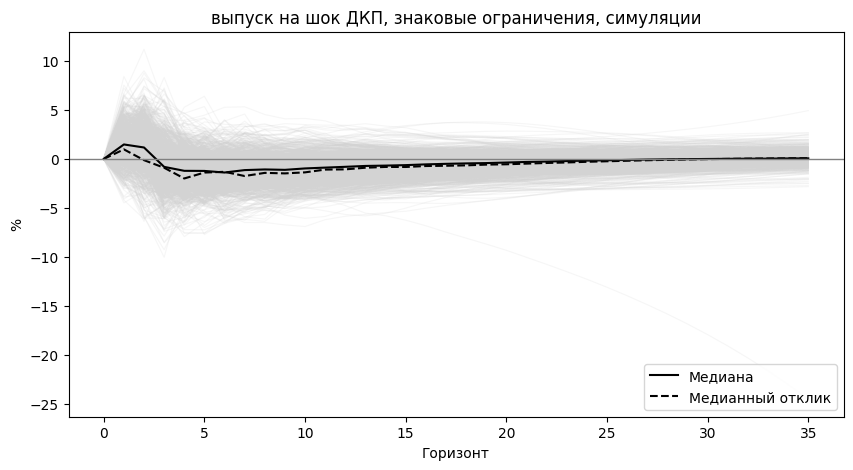

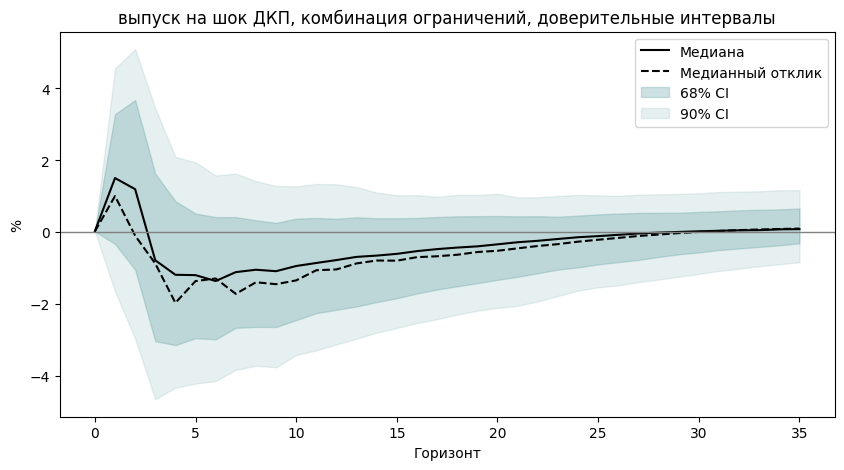

Вероятность, что суммарный отклик положительный 0.305, горизонт 36 мес.
Медианный суммарный отклик  -12.56316, горизонт 36 мес.
Верхние 95% суммарный отклик  51.42097, горизонт 36 мес.
Нижние 5% суммарный отклик  -83.38772, горизонт 36 мес.
[0, 3]


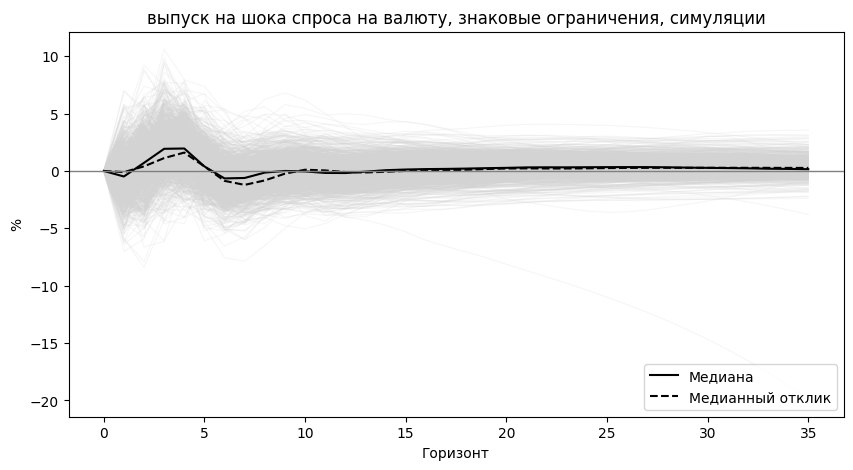

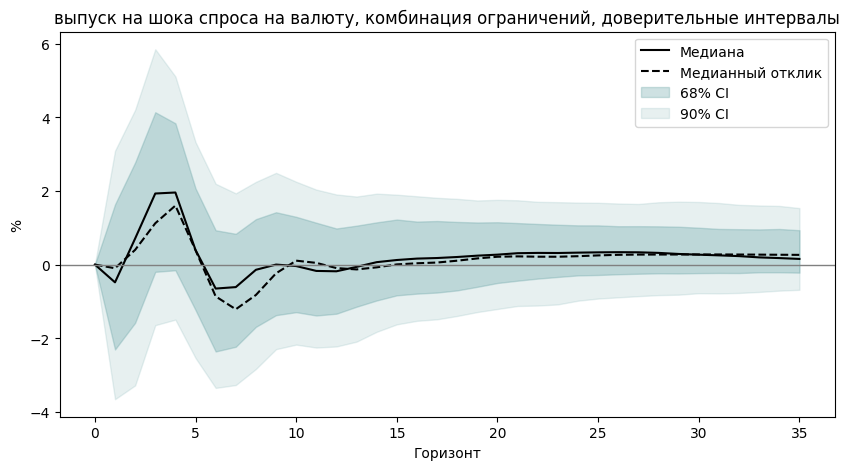

Вероятность, что суммарный отклик положительный 0.673, горизонт 36 мес.
Медианный суммарный отклик  8.02186, горизонт 36 мес.
Верхние 95% суммарный отклик  76.17512, горизонт 36 мес.
Нижние 5% суммарный отклик  -56.57098, горизонт 36 мес.
[0, 4]


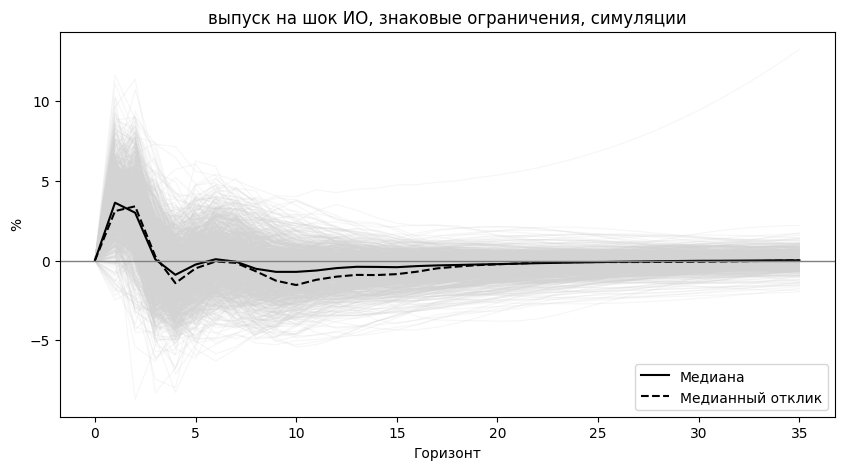

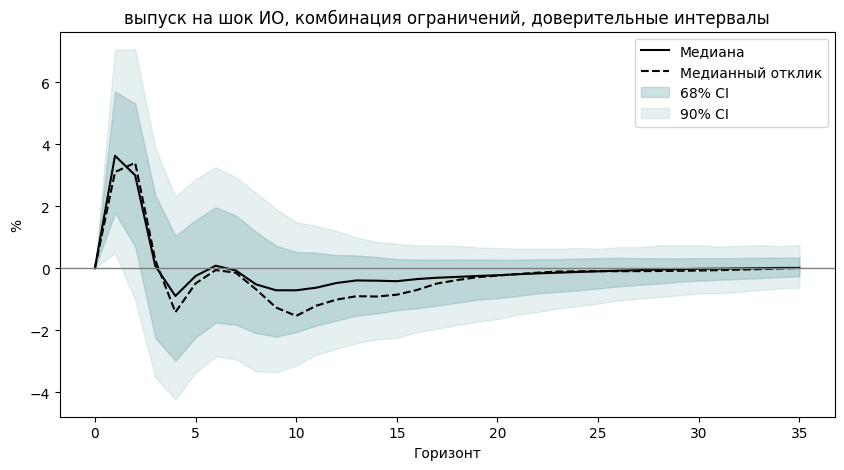

Вероятность, что суммарный отклик положительный 0.479, горизонт 36 мес.
Медианный суммарный отклик  -0.96625, горизонт 36 мес.
Верхние 95% суммарный отклик  54.31859, горизонт 36 мес.
Нижние 5% суммарный отклик  -63.44242, горизонт 36 мес.
[1, 2]


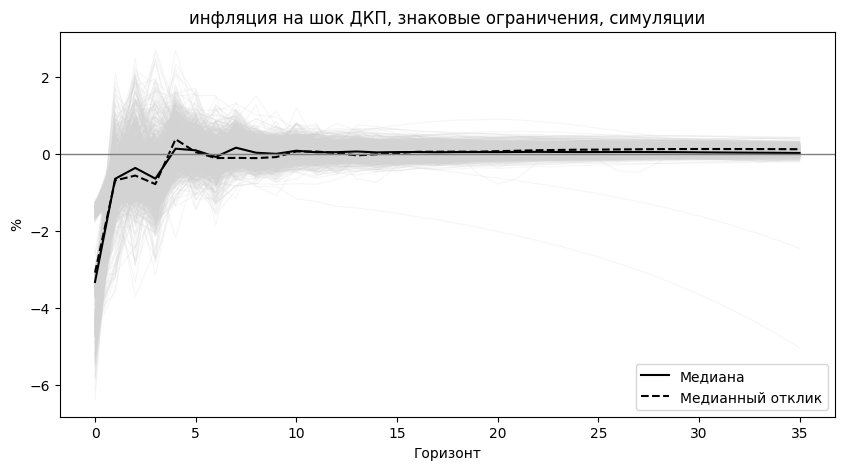

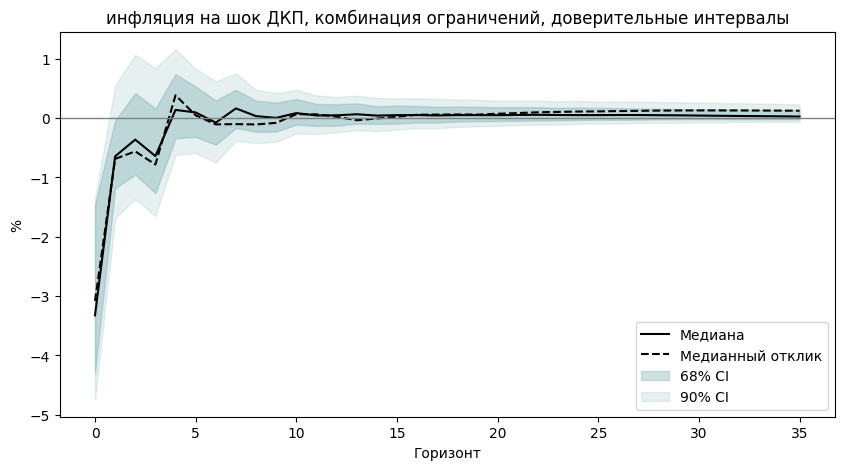

Вероятность, что суммарный отклик отрицательный 0.751, горизонт 36 мес.
Медианный суммарный отклик  -3.35245, горизонт 36 мес.
Верхние 95% суммарный отклик  13.23933, горизонт 36 мес.
Нижние 5% суммарный отклик  -16.00042, горизонт 36 мес.
[1, 3]


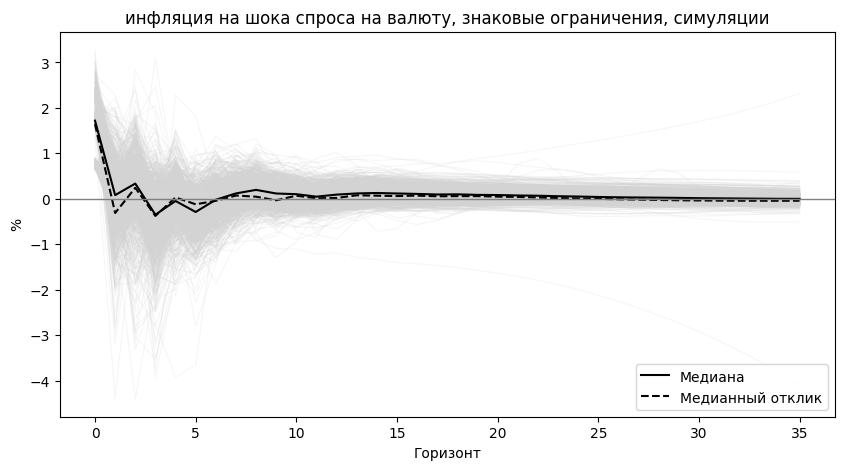

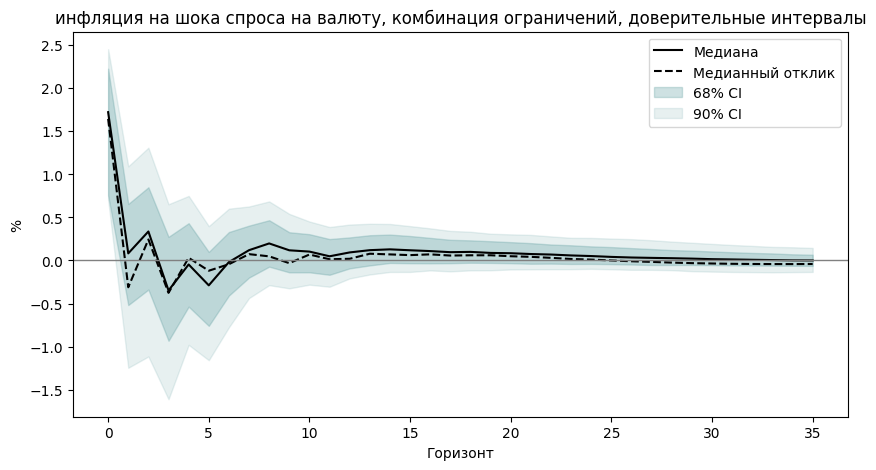

Вероятность, что суммарный отклик отрицательный 0.196, горизонт 36 мес.
Медианный суммарный отклик  3.3729, горизонт 36 мес.
Верхние 95% суммарный отклик  16.48713, горизонт 36 мес.
Нижние 5% суммарный отклик  -10.80879, горизонт 36 мес.
[1, 4]


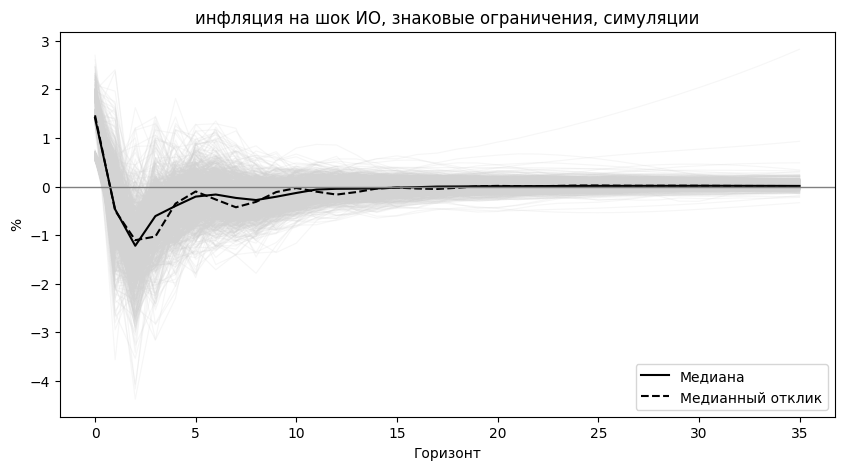

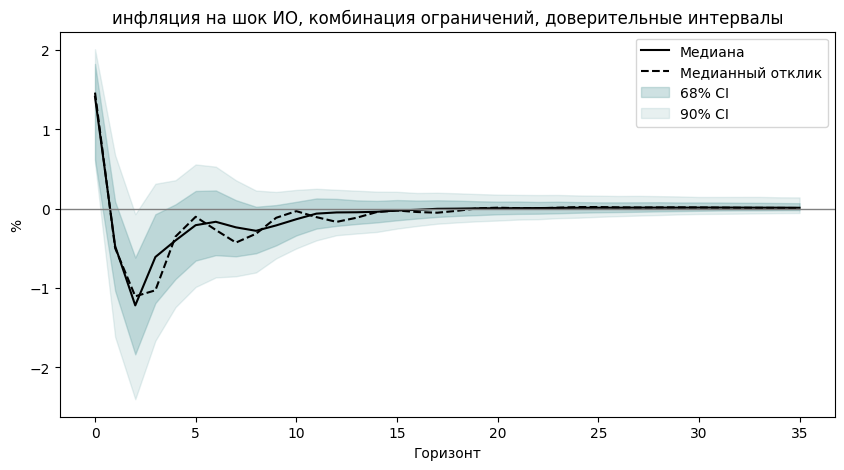

Вероятность, что суммарный отклик отрицательный 0.863, горизонт 36 мес.
Медианный суммарный отклик  -2.54418, горизонт 36 мес.
Верхние 95% суммарный отклик  9.89218, горизонт 36 мес.
Нижние 5% суммарный отклик  -14.75027, горизонт 36 мес.
[2, 2]


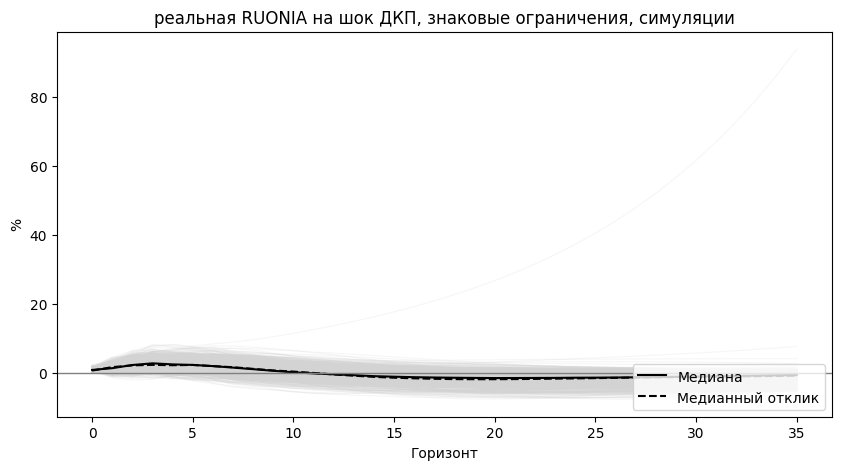

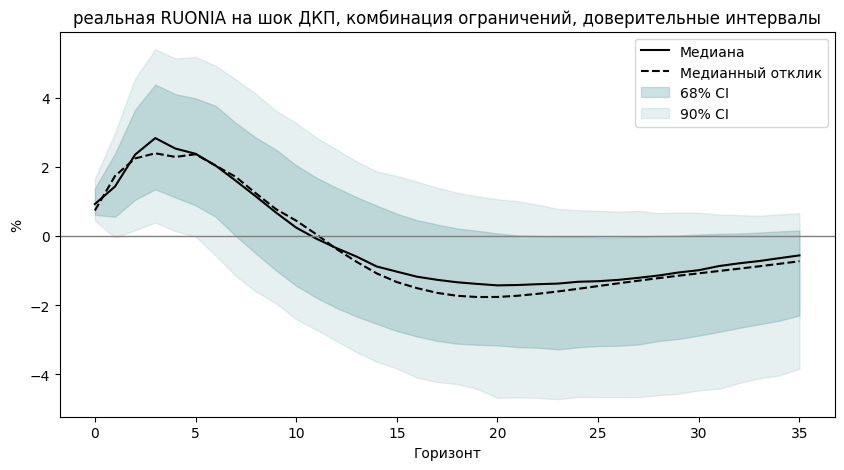

Вероятность, что суммарный отклик положительный 0.408, горизонт 36 мес.
Медианный суммарный отклик  -7.42539, горизонт 36 мес.
Верхние 95% суммарный отклик  73.61253, горизонт 36 мес.
Нижние 5% суммарный отклик  -111.81256, горизонт 36 мес.
[2, 3]


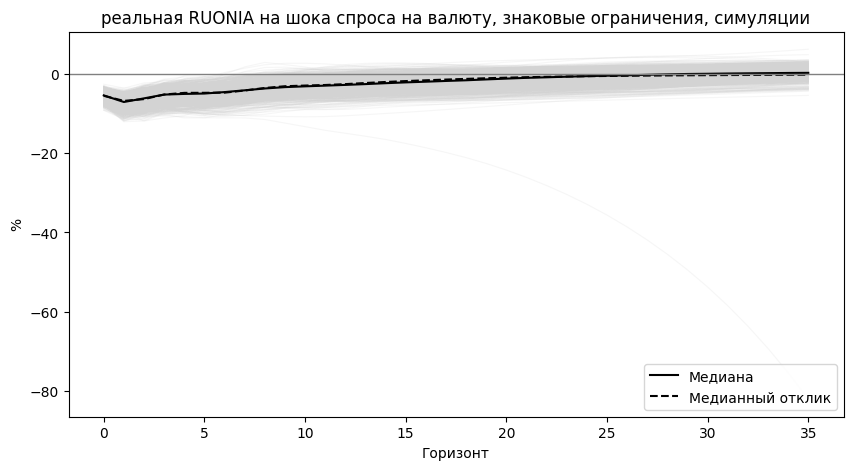

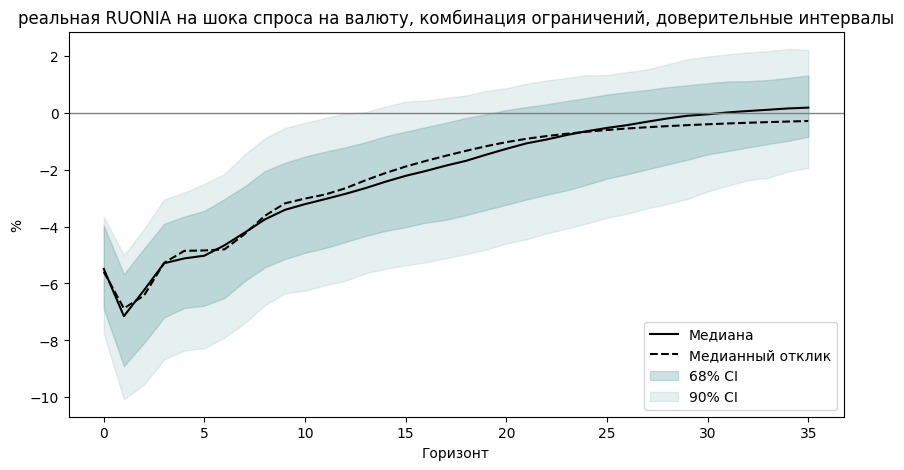

Вероятность, что суммарный отклик положительный 0.001, горизонт 36 мес.
Медианный суммарный отклик  -79.52521, горизонт 36 мес.
Верхние 95% суммарный отклик  2.61151, горизонт 36 мес.
Нижние 5% суммарный отклик  -188.00418, горизонт 36 мес.
[2, 4]


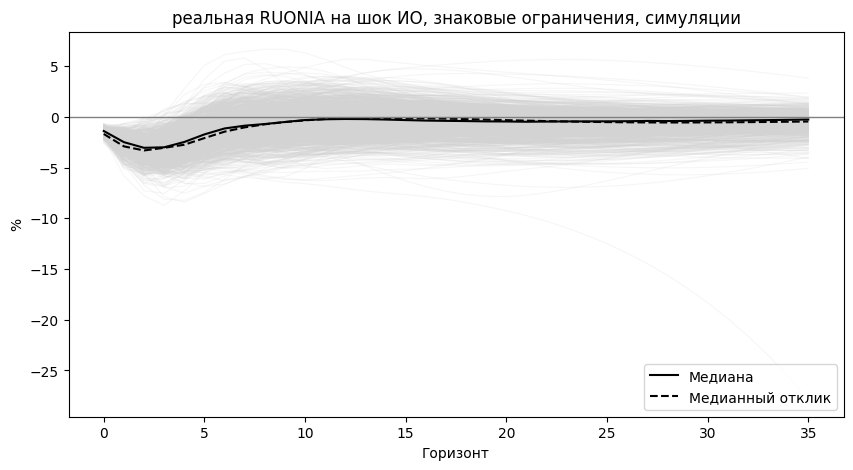

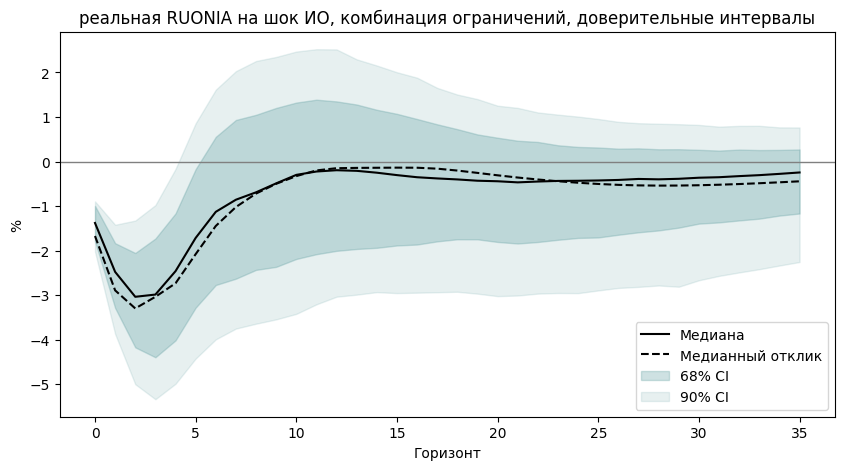

Вероятность, что суммарный отклик положительный 0.167, горизонт 36 мес.
Медианный суммарный отклик  -26.42605, горизонт 36 мес.
Верхние 95% суммарный отклик  39.48288, горизонт 36 мес.
Нижние 5% суммарный отклик  -114.7479, горизонт 36 мес.
[3, 2]


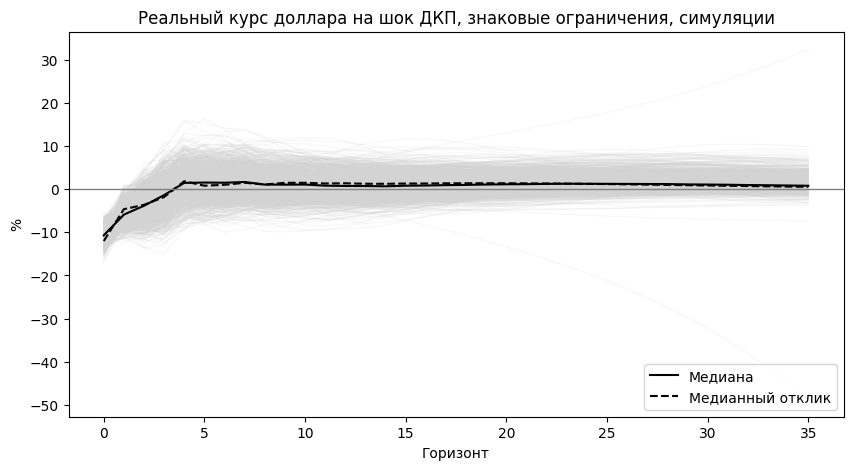

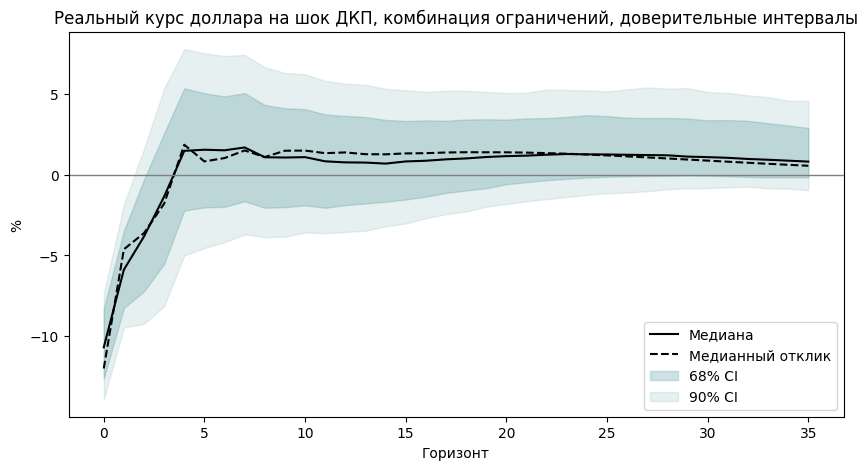

Вероятность, что суммарный отклик положительный 0.71, горизонт 36 мес.
Медианный суммарный отклик  13.33093, горизонт 36 мес.
Верхние 95% суммарный отклик  176.81132, горизонт 36 мес.
Нижние 5% суммарный отклик  -113.41463, горизонт 36 мес.
[3, 3]


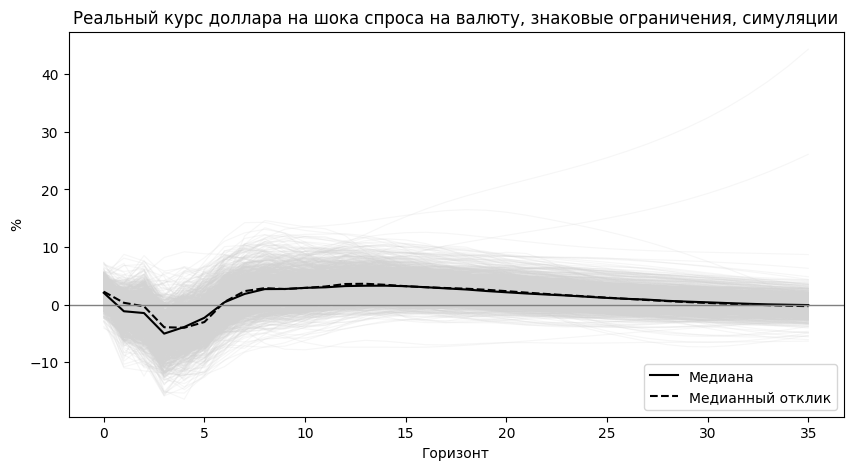

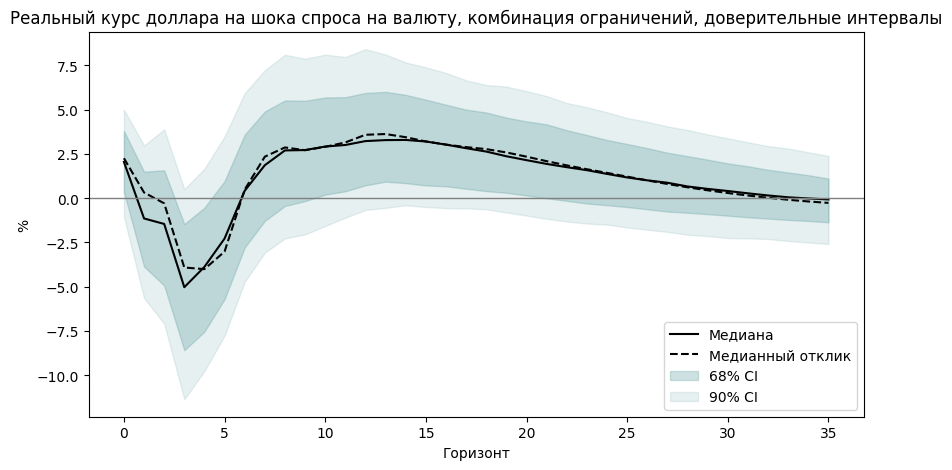

Вероятность, что суммарный отклик положительный 0.8, горизонт 36 мес.
Медианный суммарный отклик  39.5886, горизонт 36 мес.
Верхние 95% суммарный отклик  185.62654, горизонт 36 мес.
Нижние 5% суммарный отклик  -92.41326, горизонт 36 мес.
[3, 4]


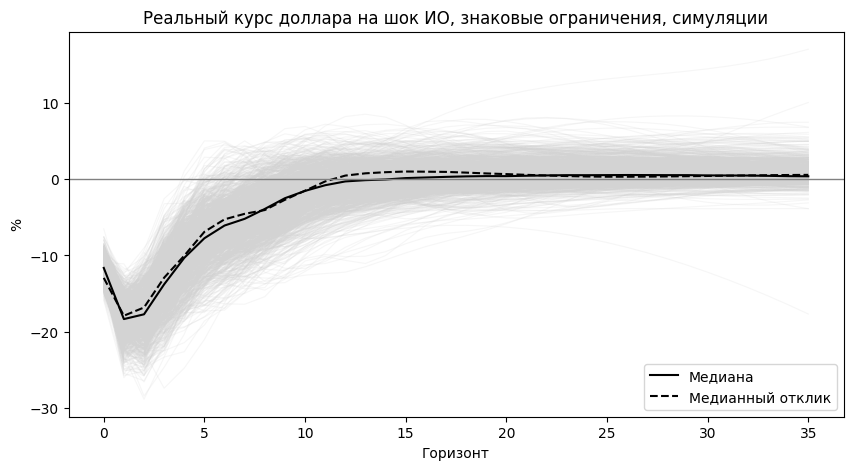

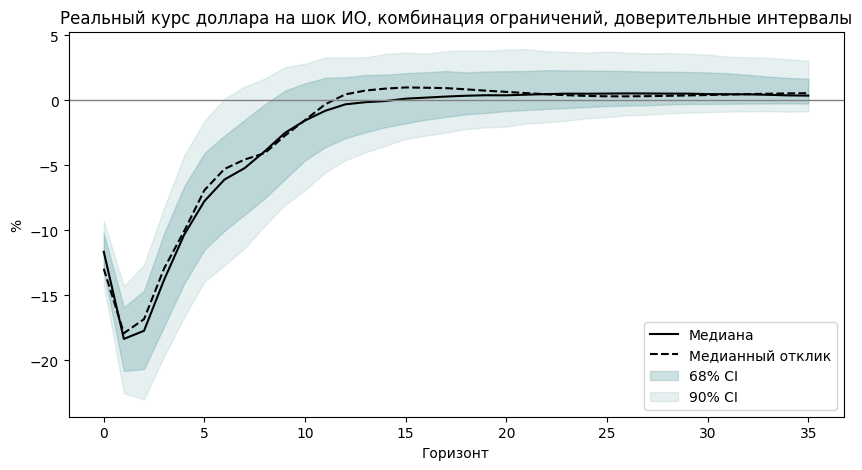

Вероятность, что суммарный отклик положительный 0.005, горизонт 36 мес.
Медианный суммарный отклик  -91.24975, горизонт 36 мес.
Верхние 95% суммарный отклик  47.01099, горизонт 36 мес.
Нижние 5% суммарный отклик  -207.72225, горизонт 36 мес.
[4, 2]


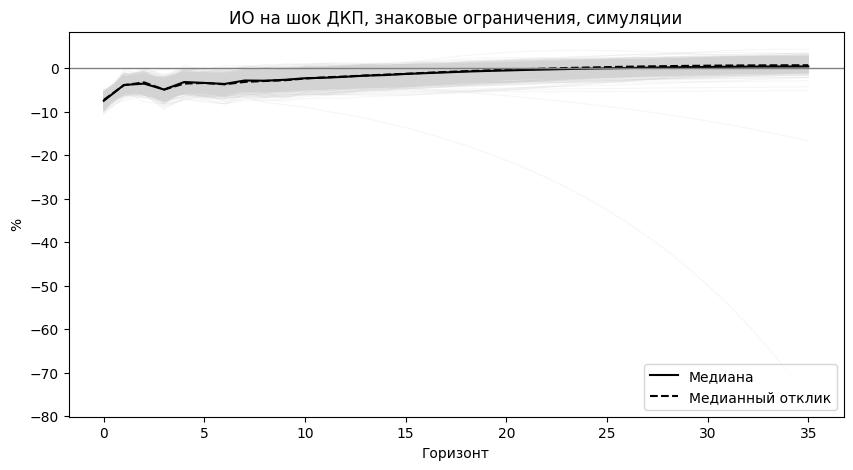

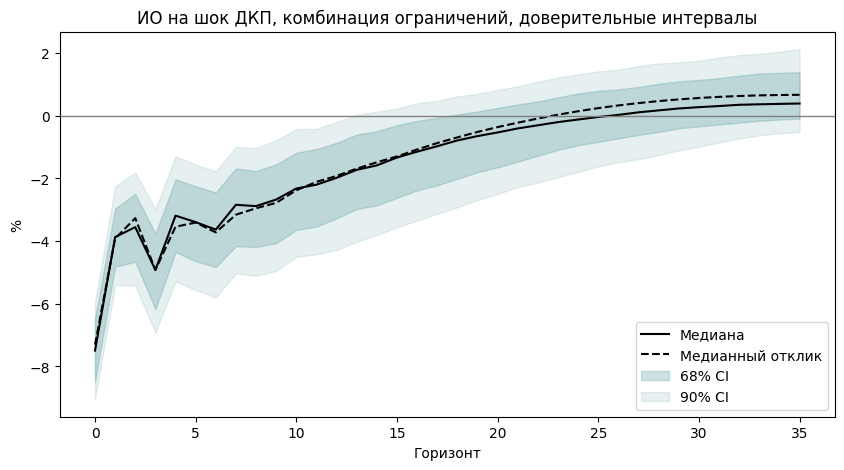

Вероятность, что суммарный отклик положительный 0.005, горизонт 36 мес.
Медианный суммарный отклик  -52.21927, горизонт 36 мес.
Верхние 95% суммарный отклик  5.95592, горизонт 36 мес.
Нижние 5% суммарный отклик  -117.02374, горизонт 36 мес.
[4, 3]


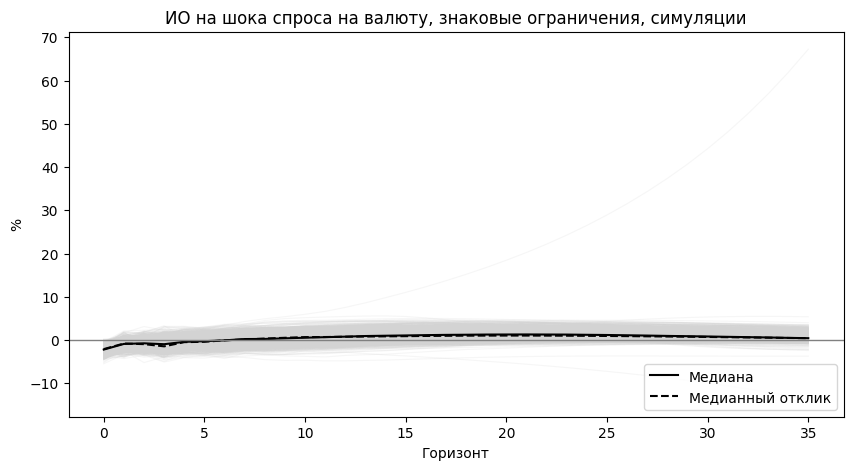

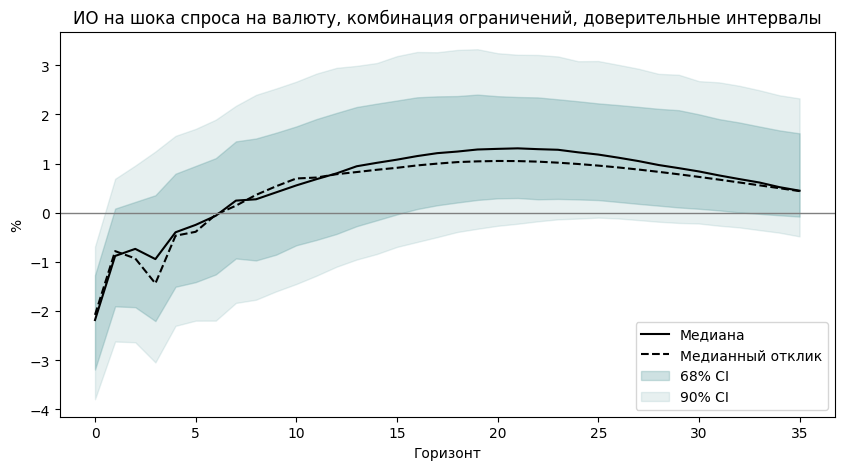

Вероятность, что суммарный отклик положительный 0.804, горизонт 36 мес.
Медианный суммарный отклик  21.00528, горизонт 36 мес.
Верхние 95% суммарный отклик  91.05818, горизонт 36 мес.
Нижние 5% суммарный отклик  -35.79981, горизонт 36 мес.
[4, 4]


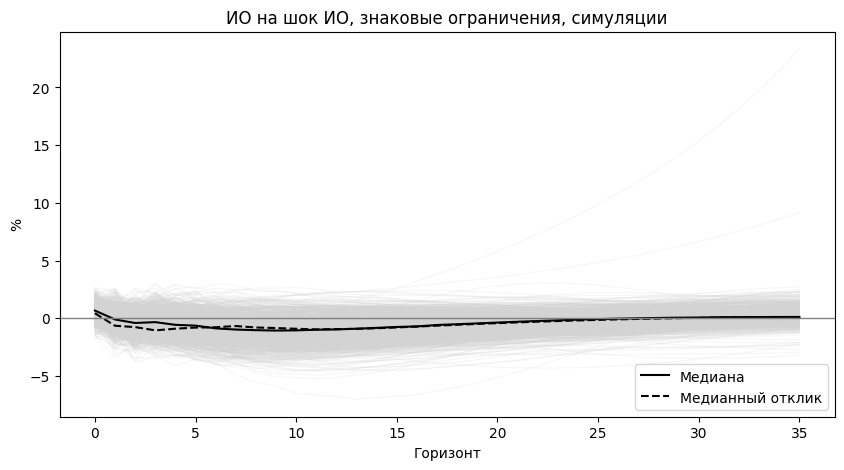

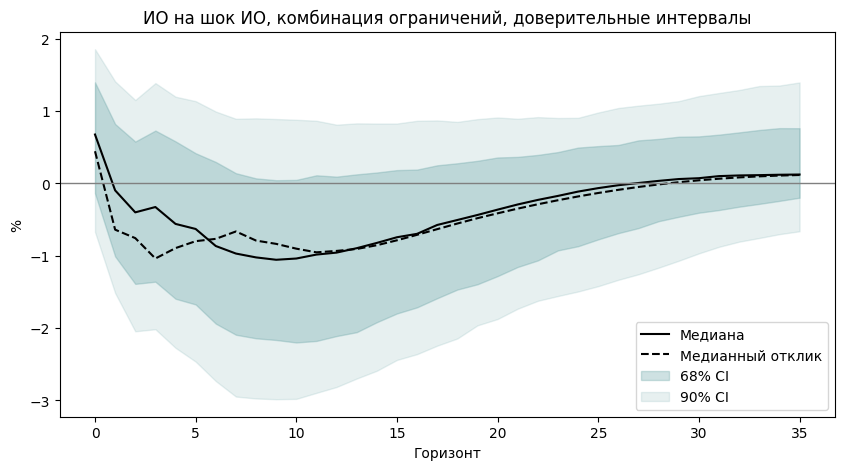

Вероятность, что суммарный отклик положительный 0.23, горизонт 36 мес.
Медианный суммарный отклик  -13.42356, горизонт 36 мес.
Верхние 95% суммарный отклик  38.06179, горизонт 36 мес.
Нижние 5% суммарный отклик  -67.05797, горизонт 36 мес.


In [15]:


for i, j in [(i, j) for i in range(K_endo) for j in range(2, K_endo)]:
    irf = IRF_ortho[0]
    response = [i, j]
    print(response)
    virf = irf[:, response[0], response[1]]
    
    for irf in IRF_ortho[1:]:
        virf = np.vstack([virf, irf[:, response[0], response[1]]])
    median_index = pd.DataFrame((virf - np.median(virf, axis = 0))**2).sum(1).sort_values().index[0]
    import matplotlib.pyplot as plt

    # Имитация матрицы: 10000 симуляций × 20 шагов
    np.random.seed(0)
    responses = virf
    rescale = False
    if rescale:
        depend = data.iloc[response[0]].std()
        shock = data.iloc[response[1]].std()
        virf *= shock/depend
    # Квантили
    if j == 2:
        sign = 1
    else:
        sign = 1
    median = sign*np.percentile(responses, 50, axis=0)
    lower68 = sign*np.percentile(responses, 16, axis=0)
    upper68 = sign*np.percentile(responses, 84, axis=0)
    lower90 = sign*np.percentile(responses, 5, axis=0)
    upper90 = sign*np.percentile(responses, 95, axis=0)
    med_res = sign*virf[median_index, :]
    median_s = median.sum()
    upper90_s = upper90.sum()
    # Горизонты
    x_axis = np.arange(horizon)
    plt.figure(figsize=(10,5))
    plt.plot(x_axis, virf.T, color="lightgray", alpha=0.2, linewidth=0.8, label="_nolabel_")
    plt.plot(x_axis, median, color='black', label='Медиана')
    
    plt.plot(x_axis, med_res, color='black', ls = '--', label='Медианный отклик')
    plt.axhline(0, color='grey', lw=1)
    plt.xlabel("Горизонт")
    plt.ylabel("%")
    plt.legend(loc = 'lower right')
    plt.title(f"{y_dict[response[0]]} на {u_dict[response[1]]}, знаковые ограничения, симуляции")
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(x_axis, median, color='black', label='Медиана')
    
    plt.plot(x_axis, med_res, color='black', ls = '--', label='Медианный отклик')
    plt.fill_between(x_axis, lower68, upper68, color='cadetblue', alpha=0.3, label='68% CI')
    plt.fill_between(x_axis, lower90, upper90, color='cadetblue', alpha=0.15, label='90% CI')
    plt.axhline(0, color='grey', lw=1)
    plt.xlabel("Горизонт")
    plt.ylabel("%")
    plt.legend()
    plt.title(f"{y_dict[response[0]]} на {u_dict[response[1]]}, комбинация ограничений, доверительные интервалы")
    plt.show()
    print(f"Вероятность, что суммарный отклик {'отрицательный' if i == 1 else 'положительный'} {((virf.sum(axis = 1) < 0).sum()/required)\
                                                                         .item() if i == 1 else ((virf.sum(axis = 1) > 0).sum()/required).item()}, горизонт {horizon} мес.")
    print(f"Медианный суммарный отклик  {np.round(np.median(virf, axis = 0).sum(), 5)}, горизонт {horizon} мес.")
    print(f"Верхние 95% суммарный отклик  {np.round(np.quantile(virf, 0.95, axis = 0).sum(), 5)}, горизонт {horizon} мес.")
    print(f"Нижние 5% суммарный отклик  {np.round(np.quantile(virf, 0.05, axis = 0).sum(), 5)}, горизонт {horizon} мес.")

In [12]:
import matplotlib.pyplot as plt

def plot_hd_bars_signed(df_hd, 
                        
                        variable_name="y", 
                        shocks_labels=None, 
                        cumm = True, 
                        var_names = list(y_dict.values())):
    shocks_labels = shocks_labels or [i for i in df_hd.columns if i not in var_names]
    x = np.arange(len(df_hd))
    x = x - 12 + df_hd.index.to_list()[0].month - 1

    plt.figure(figsize=(10, 6))

    # Основания для положительных и отрицательных значений
    bottom_pos = np.zeros(len(df_hd))
    bottom_neg = np.zeros(len(df_hd))

    # Используем палитру заранее, чтобы цвета не повторялись
    list_of_colors = ['powderblue', 'moccasin', 'salmon', 'lightgreen', 'thistle']
    color_of_variable = 'black'
    colors = list_of_colors[:len(shocks_labels)]

    for i, shock in enumerate(shocks_labels):
        values = df_hd[shock].values
        pos = np.where(values > 0, values, 0)
        neg = np.where(values < 0, values, 0)

        color = colors[i]

        # Рисуем обе части одним цветом
        plt.bar(x, pos, bottom=bottom_pos, color=color, alpha=0.8)
        plt.bar(x, neg, bottom=bottom_neg, color=color, alpha=0.8, label=shock)

        # Обновляем основания
        bottom_pos += pos
        bottom_neg += neg
    plt.plot(x, df_hd[variable_name], color=color_of_variable, linewidth=2, label=variable_name)
    plt.xticks(
        ticks=x[x % 12 == 0],
        labels=[i.year for i in df_hd.index[x % 12 == 0]],
        rotation=45,
        ha="right"
    )

    plt.axhline(0, color="black", linewidth=0.8)
    plt.title(f"{'Накопленная историческая декомпозиция' if cumm else 'Историческая декомпозиция'}: {variable_name}")
    plt.legend(loc="lower right", fontsize=9)
    plt.xlabel("Год")
    plt.ylabel("Вклад шоков")
    plt.tight_layout()
    plt.show()

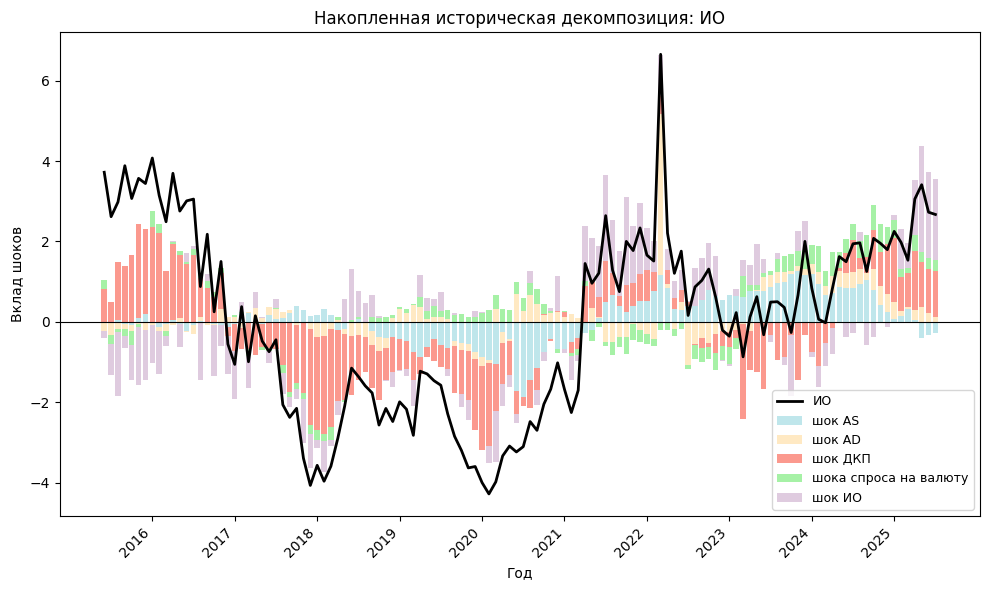

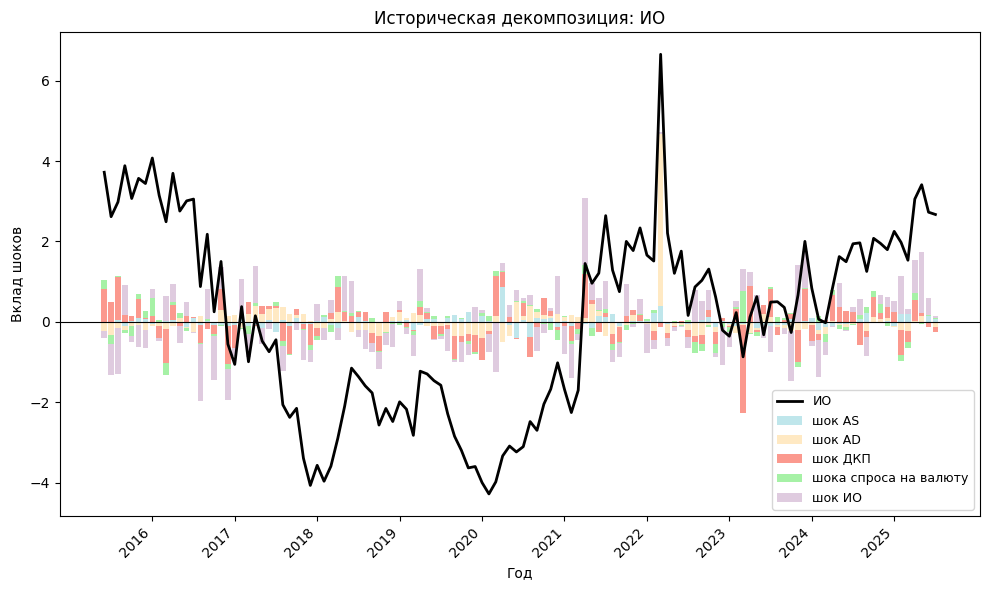

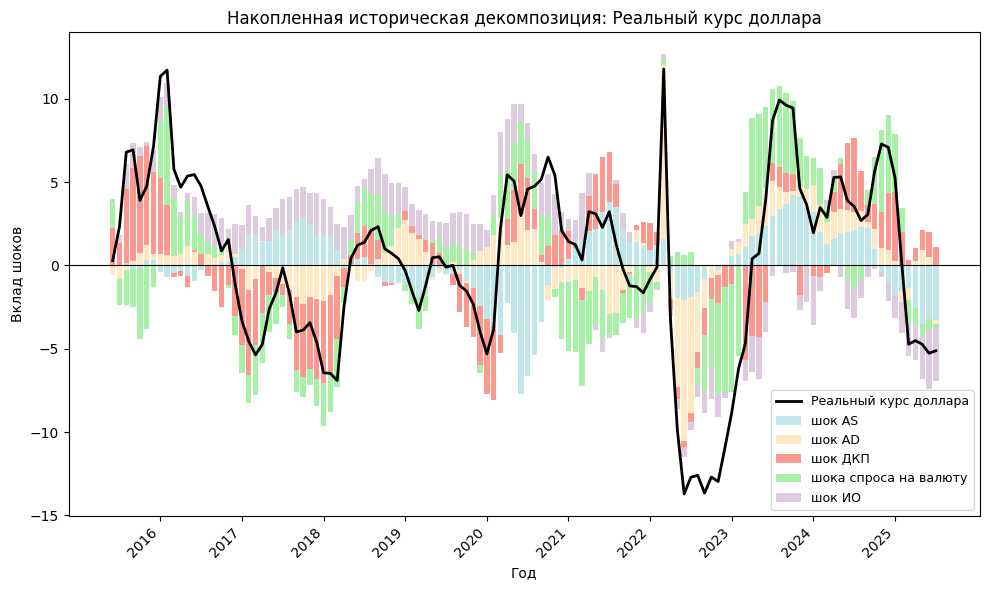

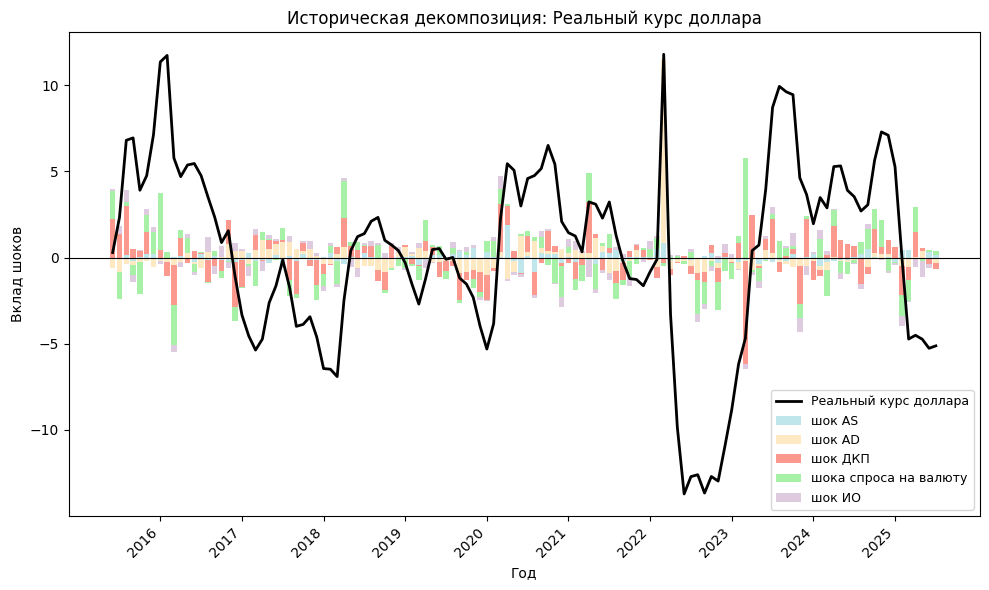

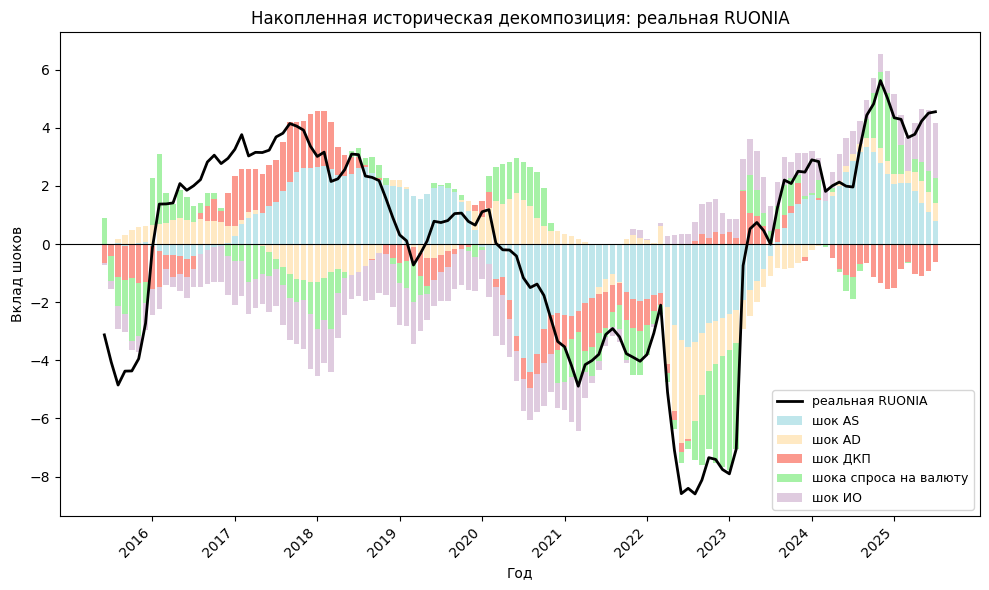

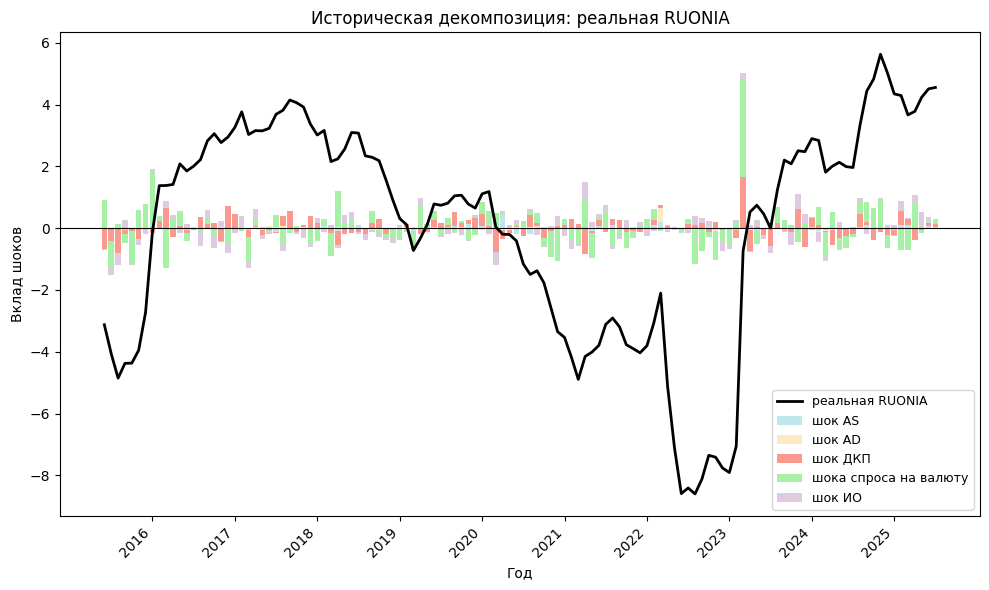

In [25]:
B0 = np.linalg.inv(P @ Q)
U = B0 @ E
U = np.flip(U, axis = 1)
T = U.shape[1]
irf = irf_companion(B_hat_endo[:, 1:], P@ Q, T)
hd = [irf[0]*U[:, 0]]
chd = [irf[0]*U[:, 0]]
for t in range(1, T):
    contrib_t = irf[0]*U[:, t]
    
    hd.append(contrib_t)

    contrib_c = irf[0]*U[:, t]
    for h in range(1, t):  
        contrib_c += irf[h]*U[:, t-h] #Этот цикл отвечает за накопленные отклики
    chd.append(contrib_c)

    del contrib_t, contrib_c

variable_of_interest = 4 #Инетерсующая нас переменная
y_hd = hd[0][variable_of_interest, :]
y_chd = chd[0][variable_of_interest, :]
for hd_t in hd[1:]:
    y_hd = np.vstack([y_hd, hd_t[variable_of_interest, :]]) 
for chd_t in chd[1:]:
    y_chd = np.vstack([y_chd, chd_t[variable_of_interest, :]])
y_hd = pd.DataFrame(y_hd, columns = [i for i in u_dict.values()], 
                    index = data.columns[:T].to_list()[::-1]) #вот не накопленные отклики

y_hd[y_dict[variable_of_interest]] = data_endo.T[y_dict[variable_of_interest]].loc[y_hd.index]


y_chd = pd.DataFrame(y_chd, columns = [i for i in u_dict.values()], 
                    index = data.columns[:T].to_list()[::-1]) #вот накопленные отклики
y_chd[y_dict[variable_of_interest]] = data_endo.T[y_dict[variable_of_interest]].loc[y_chd.index]
plot_hd_bars_signed(y_chd, variable_name=y_dict[variable_of_interest])
plot_hd_bars_signed(y_hd, variable_name=y_dict[variable_of_interest], cumm=False)

variable_of_interest = 3 #Инетерсующая нас переменная
y_hd = hd[0][variable_of_interest, :]
y_chd = chd[0][variable_of_interest, :]
for hd_t in hd[1:]:
    y_hd = np.vstack([y_hd, hd_t[variable_of_interest, :]]) 
for chd_t in chd[1:]:
    y_chd = np.vstack([y_chd, chd_t[variable_of_interest, :]])
y_hd = pd.DataFrame(y_hd, columns = [i for i in u_dict.values()], 
                    index = data.columns[:T].to_list()[::-1]) #вот не накопленные отклики

y_hd[y_dict[variable_of_interest]] = data_endo.T[y_dict[variable_of_interest]].loc[y_hd.index]


y_chd = pd.DataFrame(y_chd, columns = [i for i in u_dict.values()], 
                    index = data.columns[:T].to_list()[::-1]) #вот накопленные отклики
y_chd[y_dict[variable_of_interest]] = data_endo.T[y_dict[variable_of_interest]].loc[y_chd.index]
plot_hd_bars_signed(y_chd, variable_name=y_dict[variable_of_interest])
plot_hd_bars_signed(y_hd, variable_name=y_dict[variable_of_interest], cumm=False)

variable_of_interest = 2 #Инетерсующая нас переменная
y_hd = hd[0][variable_of_interest, :]
y_chd = chd[0][variable_of_interest, :]
for hd_t in hd[1:]:
    y_hd = np.vstack([y_hd, hd_t[variable_of_interest, :]]) 
for chd_t in chd[1:]:
    y_chd = np.vstack([y_chd, chd_t[variable_of_interest, :]])
y_hd = pd.DataFrame(y_hd, columns = [i for i in u_dict.values()], 
                    index = data.columns[:T].to_list()[::-1]) #вот не накопленные отклики

y_hd[y_dict[variable_of_interest]] = data_endo.T[y_dict[variable_of_interest]].loc[y_hd.index]


y_chd = pd.DataFrame(y_chd, columns = [i for i in u_dict.values()], 
                    index = data.columns[:T].to_list()[::-1]) #вот накопленные отклики
y_chd[y_dict[variable_of_interest]] = data_endo.T[y_dict[variable_of_interest]].loc[y_chd.index]
plot_hd_bars_signed(y_chd, variable_name=y_dict[variable_of_interest])
plot_hd_bars_signed(y_hd, variable_name=y_dict[variable_of_interest], cumm=False)

In [29]:
data_endo.iloc[2, -1*(lag+1)]

np.float64(-3.7006297041695277)

In [16]:
variable_of_interest = 2
B_hat[variable_of_interest, 1+K_endo*lag:]*data.loc['real_brent']

2025-07-01    0.009802
2025-06-01    0.007390
2025-05-01    0.009605
2025-04-01    0.007726
2025-03-01    0.004702
                ...   
2015-05-01   -0.005885
2015-04-01   -0.003382
2015-03-01   -0.000948
2015-02-01   -0.002198
2015-01-01    0.003187
Name: real_brent, Length: 127, dtype: float64

In [18]:
data.loc['real_brent']

2025-07-01   -5.360678
2025-06-01   -4.041552
2025-05-01   -5.252878
2025-04-01   -4.225030
2025-03-01   -2.571564
                ...   
2015-05-01    3.218217
2015-04-01    1.849377
2015-03-01    0.518234
2015-02-01    1.201854
2015-01-01   -1.742689
Name: real_brent, Length: 127, dtype: float64

In [ ]:
B_hat

In [13]:
matrix_a = np.array([[1, 2, 3],
                         [4, 5, 6]])
a = np.array([1, 0, -1])
matrix_a * a

array([[ 1,  0, -3],
       [ 4,  0, -6]])

In [14]:
len(hd)

122

In [15]:
data

2025-07-01  2025-06-01  2025-05-01  2025-04-01  2025-03-01  \
PMI_manufacturing   -3.774797   -3.652846   -0.325573   -0.380118   -2.852846   
ru_cpi              -0.316267   -0.336867   -0.242479   -0.306467   -0.079319   
real_ruonia          4.551915    4.506458    4.235251    3.777632    3.665222   
spread               4.177619    2.767994    1.695116    1.442357    2.283658   
log_credits_hh      -0.096406   -0.086346   -0.082164   -0.077051   -0.071438   
real_brent          -5.360678   -4.041552   -5.252878   -4.225030   -2.571564   
pi_e                 2.669904    2.727138    3.410845    3.054134    1.532012   
real_dollar         -5.124815   -5.266979   -4.738461   -4.511481   -4.729992   
covid                0.000000    0.000000    0.000000    0.000000    0.000000   

                   2025-02-01  2025-01-01  2024-12-01  2024-11-01  2024-10-01  \
PMI_manufacturing   -1.452846    0.974427   -1.180118   -0.607391   -0.825573   
ru_cpi               0.063876    0.139209    0.429199    0.336873    0.366330   
real_ruonia          4.290730    4.344939    5.031790    5.624420    4.822678   
spread               1.187939    1.223897   -0.563260   -1.431349   -1.195103   
log_credits_hh      -0.069534   -0.058733   -0.014818    0.015449    0.025838   
real_brent          -1.623382   -0.133063   -1.301953   -2.312713   -2.852753   
pi_e                 1.975485    2.249895    1.794832    1.951530    2.076625   
real_dollar          0.083156    5.262579    7.092760    7.285166    5.644690   
covid                0.000000    0.000000    0.000000    0.000000    0.000000   

                   ...  2015-10-01  2015-09-01  2015-08-01  2015-07-01  \
PMI_manufacturing  ...    0.342276   -0.521360   -1.712269   -0.732742   
ru_cpi             ...   -0.107753   -0.083392    0.017495   -0.285386   
real_ruonia        ...   -4.366637   -4.372553   -4.851893   -4.061304   
spread             ...    0.780524    0.119468   -0.240186    0.760617   
log_credits_hh     ...    0.048007    0.060690    0.086936    0.100444   
real_brent         ...   -4.454908   -4.645519   -4.225194   -1.787567   
pi_e               ...    3.067810    3.883423    2.980463    2.615503   
real_dollar        ...    3.903410    6.937763    6.801027    2.327151   
covid              ...    0.000000    0.000000    0.000000    0.000000   

                   2015-06-01  2015-05-01  2015-04-01  2015-03-01  2015-02-01  \
PMI_manufacturing   -0.710791   -1.183518    0.961936   -1.210791   -0.210791   
ru_cpi              -0.288914   -0.215638   -0.090351    0.523149    1.455597   
real_ruonia         -3.124843   -3.700630   -3.334572   -3.618860   -2.436491   
spread               1.377285    1.417940    1.564545    0.918292    1.389290   
log_credits_hh       0.117438    0.133447    0.152520    0.177083    0.199646   
real_brent           2.202691    3.218217    1.849377    0.518234    1.201854   
pi_e                 3.720581    3.388204    2.968513    3.313873    5.380410   
real_dollar          0.288980   -3.200444   -2.802542    1.421163    6.182079   
covid                0.000000    0.000000    0.000000    0.000000    0.000000   

                   2015-01-01  
PMI_manufacturing   -2.783518  
ru_cpi               2.482129  
real_ruonia          0.428302  
spread               1.122918  
log_credits_hh       0.228935  
real_brent          -1.742689  
pi_e                 3.836426  
real_dollar          5.043736  
covid                0.000000  

[9 rows x 127 columns]

In [ ]:
lag, lag_ex = 4, 1

Z, Y, B_hat, E, K, T, B_hat_endo, P = OLS_estimation( # type: ignore
    data.loc[[
    'PMI_manufacturing',
    'ru_cpi',
    'real_ruonia',
    '',
    'pi_e'
       
], :], 
    lag = lag, 
    exog_data = data.loc[[
    'real_brent'
], :],  # type: ignore
    lag_exog=lag_ex)
K_endo, K_exog = P.shape[0], B_hat.shape[1] - K*lag - 1
u_dict = {0: 'шок AS',
          1: 'шок AD',
          2: 'шок ДКП',
          3: 'шока спроса на валюту',
          4: 'шок ИО'}
y_dict = {0: 'выпуск',
          1: 'инфляция',
          2: 'реальная RUONIA',
          3: 'Реальный курс доллара',
          4: 'ИО'}


data_endo = data.loc[[
    'PMI_manufacturing',
    'ru_cpi',
    'real_ruonia',
    'real_dollar',
    'pi_e']].copy(deep=True)
data_endo = data_endo.rename(index = {k:v for k, v in zip(data_endo.index.to_list(),[i for i in y_dict.values()])})

10

In [5]:
data


2025-07-01  2025-06-01  2025-05-01  2025-04-01  2025-03-01  \
PMI_manufacturing   -3.774797   -3.652846   -0.325573   -0.380118   -2.852846   
ru_cpi              -0.316267   -0.336867   -0.242479   -0.306467   -0.079319   
real_ruonia          4.551915    4.506458    4.235251    3.777632    3.665222   
spread               4.177619    2.767994    1.695116    1.442357    2.283658   
log_credits_hh      -0.096406   -0.086346   -0.082164   -0.077051   -0.071438   
real_brent          -5.360678   -4.041552   -5.252878   -4.225030   -2.571564   
pi_e                 2.669904    2.727138    3.410845    3.054134    1.532012   
real_dollar         -5.124815   -5.266979   -4.738461   -4.511481   -4.729992   
covid                0.000000    0.000000    0.000000    0.000000    0.000000   

                   2025-02-01  2025-01-01  2024-12-01  2024-11-01  2024-10-01  \
PMI_manufacturing   -1.452846    0.974427   -1.180118   -0.607391   -0.825573   
ru_cpi               0.063876    0.139209    0.429199    0.336873    0.366330   
real_ruonia          4.290730    4.344939    5.031790    5.624420    4.822678   
spread               1.187939    1.223897   -0.563260   -1.431349   -1.195103   
log_credits_hh      -0.069534   -0.058733   -0.014818    0.015449    0.025838   
real_brent          -1.623382   -0.133063   -1.301953   -2.312713   -2.852753   
pi_e                 1.975485    2.249895    1.794832    1.951530    2.076625   
real_dollar          0.083156    5.262579    7.092760    7.285166    5.644690   
covid                0.000000    0.000000    0.000000    0.000000    0.000000   

                   ...  2015-10-01  2015-09-01  2015-08-01  2015-07-01  \
PMI_manufacturing  ...    0.342276   -0.521360   -1.712269   -0.732742   
ru_cpi             ...   -0.107753   -0.083392    0.017495   -0.285386   
real_ruonia        ...   -4.366637   -4.372553   -4.851893   -4.061304   
spread             ...    0.780524    0.119468   -0.240186    0.760617   
log_credits_hh     ...    0.048007    0.060690    0.086936    0.100444   
real_brent         ...   -4.454908   -4.645519   -4.225194   -1.787567   
pi_e               ...    3.067810    3.883423    2.980463    2.615503   
real_dollar        ...    3.903410    6.937763    6.801027    2.327151   
covid              ...    0.000000    0.000000    0.000000    0.000000   

                   2015-06-01  2015-05-01  2015-04-01  2015-03-01  2015-02-01  \
PMI_manufacturing   -0.710791   -1.183518    0.961936   -1.210791   -0.210791   
ru_cpi              -0.288914   -0.215638   -0.090351    0.523149    1.455597   
real_ruonia         -3.124843   -3.700630   -3.334572   -3.618860   -2.436491   
spread               1.377285    1.417940    1.564545    0.918292    1.389290   
log_credits_hh       0.117438    0.133447    0.152520    0.177083    0.199646   
real_brent           2.202691    3.218217    1.849377    0.518234    1.201854   
pi_e                 3.720581    3.388204    2.968513    3.313873    5.380410   
real_dollar          0.288980   -3.200444   -2.802542    1.421163    6.182079   
covid                0.000000    0.000000    0.000000    0.000000    0.000000   

                   2015-01-01  
PMI_manufacturing   -2.783518  
ru_cpi               2.482129  
real_ruonia          0.428302  
spread               1.122918  
log_credits_hh       0.228935  
real_brent          -1.742689  
pi_e                 3.836426  
real_dollar          5.043736  
covid                0.000000  

[9 rows x 127 columns]

In [6]:
monthly_data.columns

Index(['key_rate', 'infl', 'target', 'dollar_m', 'm0', 'm1', 'm2', 'pi_e_ws',
       'pi_e_wos', 'pi_e', 'credits_hh', 'PMI_manufacturing', 'PMI_service',
       'price_brent', 'ruonia_1w', 'ruonia_2w', 'ruonia_1m', 'ruonia_2m',
       'ruonia_3m', 'ruonia_6m', 'ruonia_1y', 'ruonia_2y', 'rate_1', 'rate_05',
       'rate_025', 'inf_us', 'inf_us_cum', 'igrea', 'all_items', 'ru_cpi',
       'ru_cpi_wo_servises', 'ruonia', 'm2x_sa_mom', 'm2_sa_mom', 'm1_sa_mom',
       'real_brent', 'rcwos_c', 'rc_c', 'real_dollar', 'real_rate',
       'real_ruonia', 'log_credits_hh', 'spread', 'pi_spread'],
      dtype='object')